<a href="https://colab.research.google.com/github/Aakame/HoudaB.github.io/blob/main/Accounts_Quality_Assessment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Merchants Given to new joiners - Quality Assessment

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
df = pd.read_csv('Accounts Quality Assessment.csv')

# Convert date columns
date_cols = [
    'last_assignation_date', 'last_purchase_date', 'last_car_view',
    'last_login_date', 'creation_date', 'assignation_month'
]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# General stats
total_merchants = len(df)
total_accounts = (df['lead_or_account'] == 'account').sum()
total_leads = (df['lead_or_account'] == 'lead').sum()

print(f"Total merchants (accounts + leads): {total_merchants}")
print(f"  - Accounts: {total_accounts}")
print(f"  - Leads:    {total_leads}")


Total merchants (accounts + leads): 12300
  - Accounts: 5968
  - Leads:    6332


## 1. Accounts:

In [2]:
# Filter accounts
accounts = df[df['lead_or_account'] == 'account'].copy()
# Key columns for accounts
account_cols = ['days_last_purchase', 'days_last_car_view', 'ncs_alltime', 'nb_assignations']

# Calculate summary stats
summary = accounts[account_cols].agg(['mean', 'median', 'std', 'min', 'max']).T
summary['missing'] = accounts[account_cols].isnull().sum()

# Display as a table
print("Accounts - Key Statistics:")
display(summary)



Accounts - Key Statistics:


,mean,median,std,min,max,missing
days_last_purchase,1116.041555,895.0,945.655385,1.0,3955.0,0
days_last_car_view,307.980776,72.0,520.108511,1.0,3180.0,38
ncs_alltime,16.494638,4.0,48.473459,1.0,1492.0,0
nb_assignations,15.506200,15.0,7.368076,2.0,46.0,0


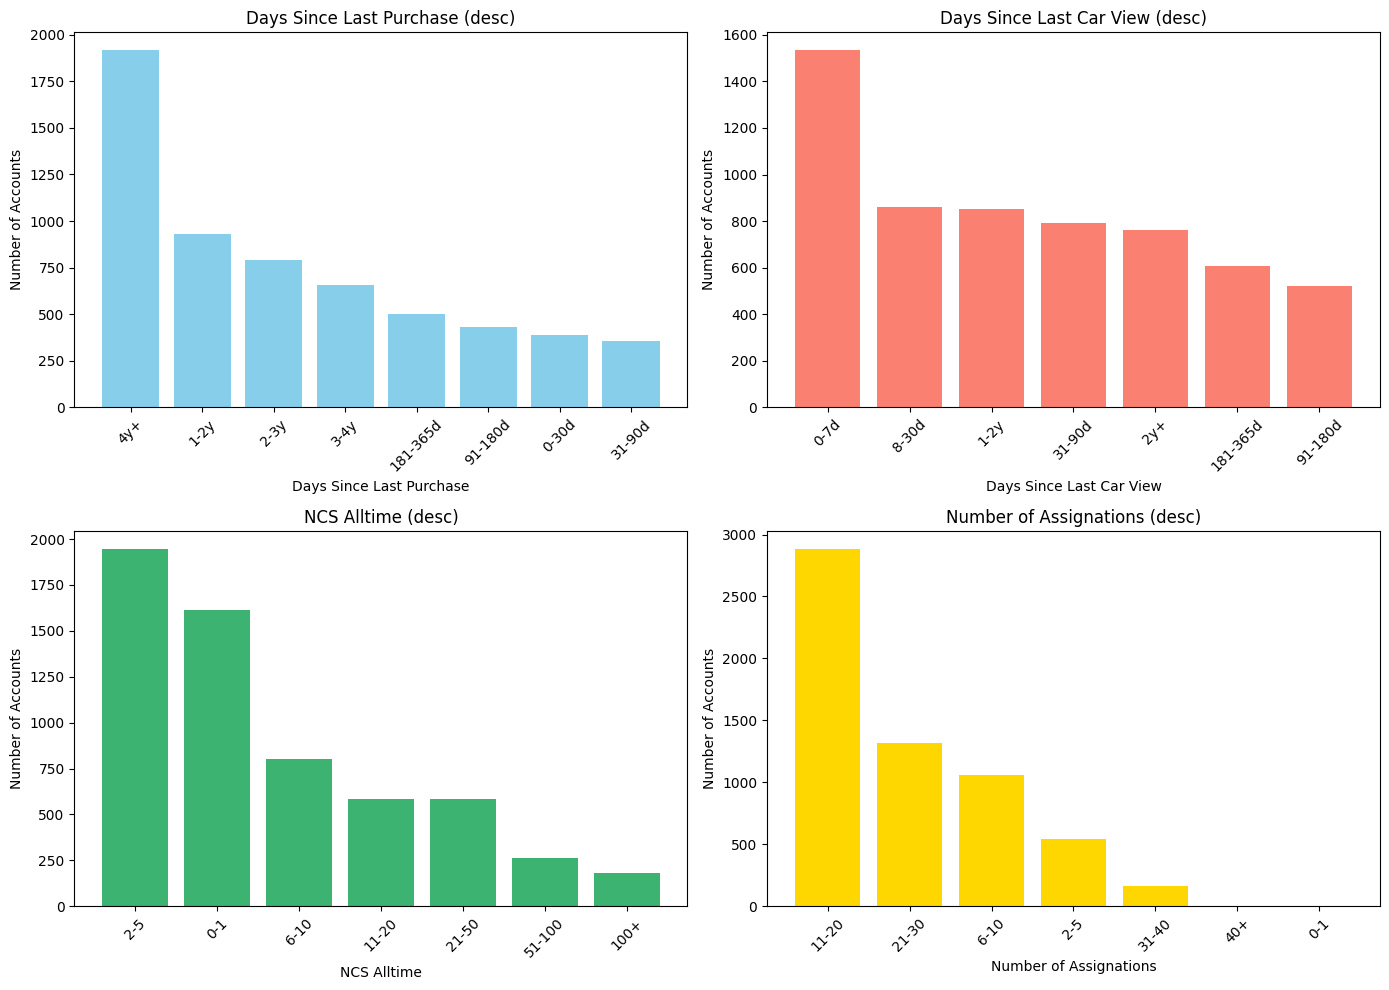

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1. Days since last purchase
bins_purchase = [0, 30, 90, 180, 365, 730, 1095, 1460, np.inf]
labels_purchase = ['0-30d', '31-90d', '91-180d', '181-365d', '1-2y', '2-3y', '3-4y', '4y+']
accounts['purchase_bin'] = pd.cut(accounts['days_last_purchase'], bins=bins_purchase, labels=labels_purchase, right=True, include_lowest=True)
bin_counts = accounts['purchase_bin'].value_counts().sort_values(ascending=False)
axes[0, 0].bar(bin_counts.index, bin_counts.values, color='skyblue')
axes[0, 0].set_title('Days Since Last Purchase (desc)')
axes[0, 0].set_ylabel('Number of Accounts')
axes[0, 0].set_xlabel('Days Since Last Purchase')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Days since last car view
bins_view = [0, 7, 30, 90, 180, 365, 730, np.inf]
labels_view = ['0-7d', '8-30d', '31-90d', '91-180d', '181-365d', '1-2y', '2y+']
accounts['view_bin'] = pd.cut(accounts['days_last_car_view'], bins=bins_view, labels=labels_view, right=True, include_lowest=True)
bin_counts = accounts['view_bin'].value_counts().sort_values(ascending=False)
axes[0, 1].bar(bin_counts.index, bin_counts.values, color='salmon')
axes[0, 1].set_title('Days Since Last Car View (desc)')
axes[0, 1].set_ylabel('Number of Accounts')
axes[0, 1].set_xlabel('Days Since Last Car View')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. ncs_alltime
bins_ncs = [0, 1, 5, 10, 20, 50, 100, np.inf]
labels_ncs = ['0-1', '2-5', '6-10', '11-20', '21-50', '51-100', '100+']
accounts['ncs_bin'] = pd.cut(accounts['ncs_alltime'], bins=bins_ncs, labels=labels_ncs, right=True, include_lowest=True)
bin_counts = accounts['ncs_bin'].value_counts().sort_values(ascending=False)
axes[1, 0].bar(bin_counts.index, bin_counts.values, color='mediumseagreen')
axes[1, 0].set_title('NCS Alltime (desc)')
axes[1, 0].set_ylabel('Number of Accounts')
axes[1, 0].set_xlabel('NCS Alltime')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. nb_assignations
bins_assign = [0, 1, 5, 10, 20, 30, 40, np.inf]
labels_assign = ['0-1', '2-5', '6-10', '11-20', '21-30', '31-40', '40+']
accounts['assign_bin'] = pd.cut(accounts['nb_assignations'], bins=bins_assign, labels=labels_assign, right=True, include_lowest=True)
bin_counts = accounts['assign_bin'].value_counts().sort_values(ascending=False)
axes[1, 1].bar(bin_counts.index, bin_counts.values, color='gold')
axes[1, 1].set_title('Number of Assignations (desc)')
axes[1, 1].set_ylabel('Number of Accounts')
axes[1, 1].set_xlabel('Number of Assignations')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [4]:
today = pd.Timestamp.today()
accounts['days_since_creation'] = (today - accounts['creation_date']).dt.days


In [5]:
features = [
    ('days_last_purchase', 'Avg Days Since Last Purchase'),
    ('days_last_car_view', 'Avg Days Since Last Car View'),
    ('days_since_creation', 'Avg Days Since Creation'),
    ('ncs_alltime', 'Avg NCS Alltime'),
    ('nb_assignations', 'Avg Number of Assignations')
]


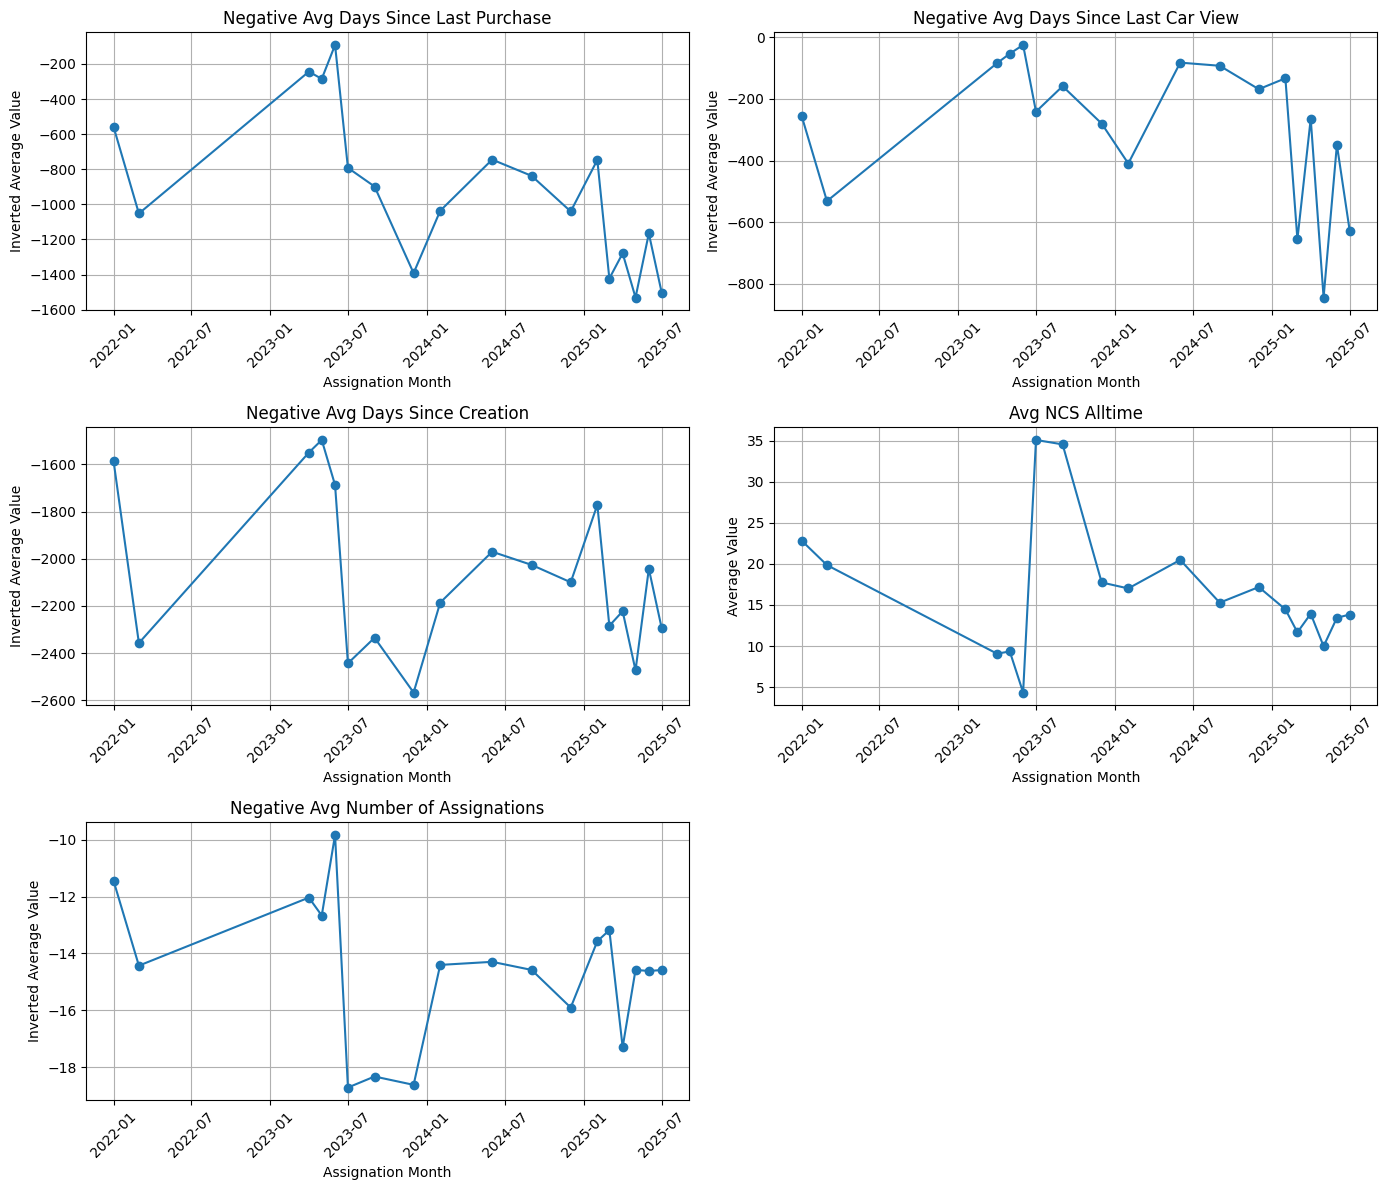

In [6]:
# Only keep features that exist in your DataFrame
existing_features = [(col, label) for col, label in features if col in accounts.columns]

# Group by assignation_month and calculate mean for each feature
monthly_stats = accounts.groupby('assignation_month')[
    [f[0] for f in existing_features]
].mean().reset_index()

# Set up grid size
n_features = len(existing_features)
n_cols = 2
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharex=False)
axes = axes.flatten()  # Flatten in case of 2D array

for i, (col, label) in enumerate(existing_features):
    # Invert all features except 'ncs_alltime'
    if col != 'ncs_alltime':
        y = -1 * monthly_stats[col]
        axes[i].set_ylabel('Inverted Average Value')
        axes[i].set_title(f'Negative {label}')
    else:
        y = monthly_stats[col]
        axes[i].set_ylabel('Average Value')
        axes[i].set_title(label)
    axes[i].plot(monthly_stats['assignation_month'], y, marker='o')

    axes[i].set_xlabel('Assignation Month')
    axes[i].grid(True)
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [7]:

# Calculate quality score for merchants
def account_quality(row):
    # Lower is better for days since events, higher is better for ncs_alltime
    score = 0
    score -= row.get('days_last_purchase', 0) * 5
    score -= row.get('days_last_car_view', 0) * 3
    score -= (pd.Timestamp.today() - row.get('creation_date', pd.Timestamp.today())).days * 1
    score += row.get('ncs_alltime', 0) * 7
    score -= row.get('nb_assignations', 0) * 2
    return score

accounts['quality_score'] = accounts.apply(account_quality, axis=1)


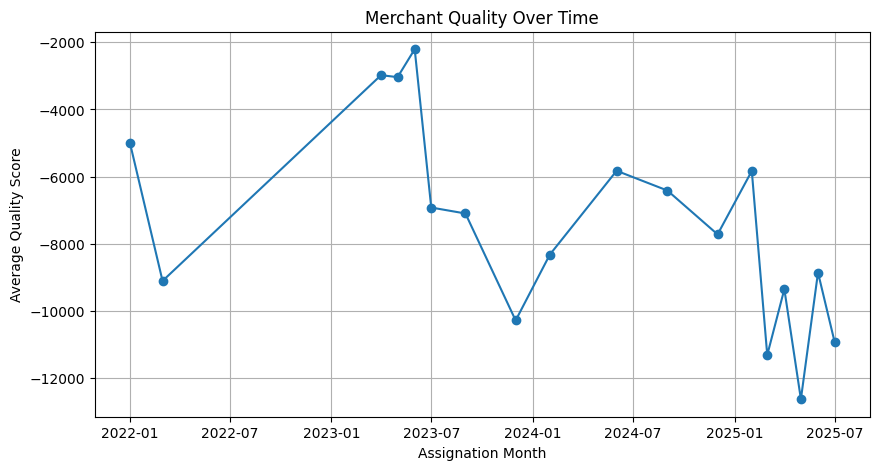

In [8]:
# Aggregate average quality by assignation_month
monthly_quality = accounts.groupby('assignation_month')['quality_score'].mean().reset_index()

# Plot
plt.figure(figsize=(10,5))
plt.plot(monthly_quality['assignation_month'], monthly_quality['quality_score'], marker='o')
plt.title('Merchant Quality Over Time')
plt.xlabel('Assignation Month')
plt.ylabel('Average Quality Score')
plt.grid(True)
plt.show()

In [9]:
min_score = accounts['quality_score'].min()
max_score = accounts['quality_score'].max()
if max_score > min_score:
    accounts['quality_score_std'] = 100 * (accounts['quality_score'] - min_score) / (max_score - min_score)
else:
    accounts['quality_score_std'] = 50  # fallback if all scores are equal

In [10]:
accounts.columns

Index(['merchant_id', 'merchant_names', 'to_user_id', 'assignee',
       'last_assignation_date', 'created_by', 'created_by_name',
       'nb_assignations', 'lead_or_account', 'banned_date', 'ncs_alltime',
       'last_purchase_date', 'avg_bask_alltime', 'last_car_view',
       'days_last_car_view', 'days_last_bid', 'days_last_purchase',
       'days_last_assignation',
       'days_since_last_answered_call_date_by_assigned_salesrep',
       'last_login_date', 'creation_date', 'mass_assignation_day',
       'assignation_month', 'srep_email', 'purchase_bin', 'view_bin',
       'ncs_bin', 'assign_bin', 'days_since_creation', 'quality_score',
       'quality_score_std'],
      dtype='object')

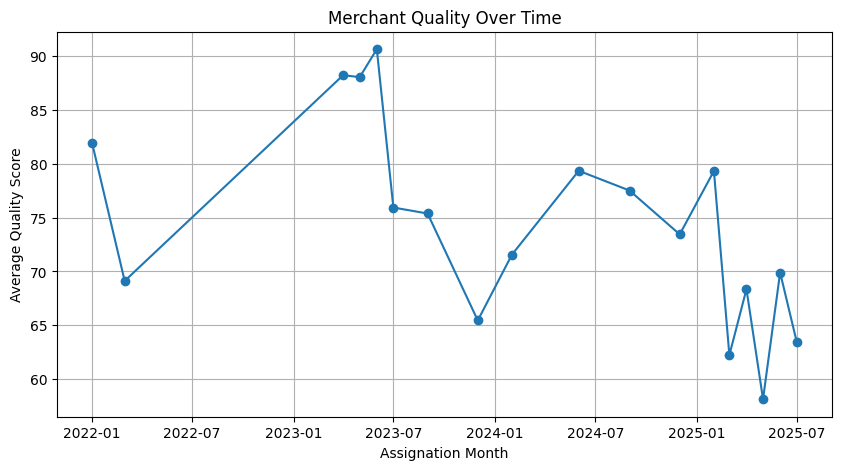

In [11]:
# Standardized quality score
monthly_quality_std = accounts.groupby('assignation_month')['quality_score_std'].mean().reset_index()

# Plot
plt.figure(figsize=(10,5))
plt.plot(monthly_quality_std['assignation_month'], monthly_quality_std['quality_score_std'], marker='o')
plt.title('Merchant Quality Over Time')
plt.xlabel('Assignation Month')
plt.ylabel('Average Quality Score')
plt.grid(True)
plt.show()

In [12]:
#todo inverser les courbes
# fin equipe ssu marker aout 2023


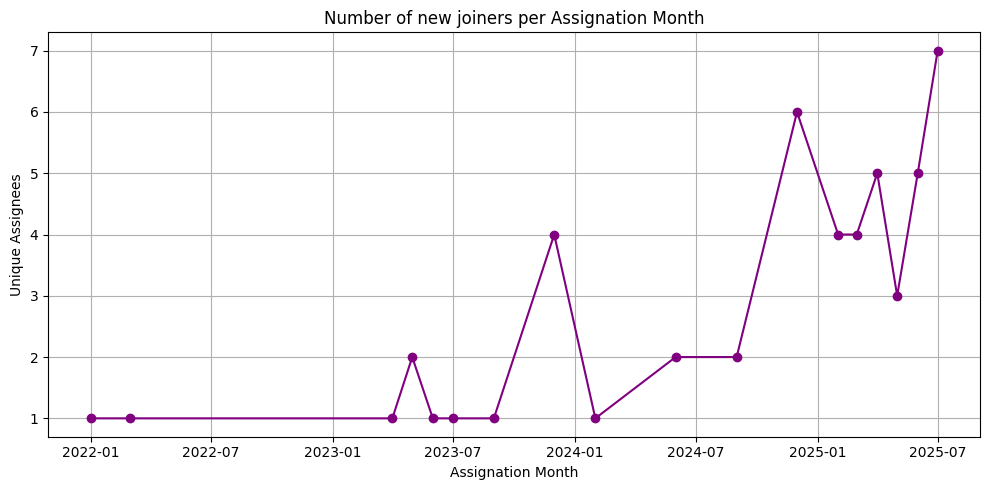

In [13]:
# For accounts (or leads), count unique assignees per assignation month
monthly_unique_assignees = (
    accounts.groupby('assignation_month')['assignee']
    .nunique()
    .reset_index(name='unique_assignees')
)

plt.figure(figsize=(10,5))
plt.plot(monthly_unique_assignees['assignation_month'], monthly_unique_assignees['unique_assignees'], marker='o', color='purple')
plt.title('Number of new joiners per Assignation Month')
plt.xlabel('Assignation Month')
plt.ylabel('Unique Assignees')
plt.grid(True)
plt.tight_layout()
plt.show()


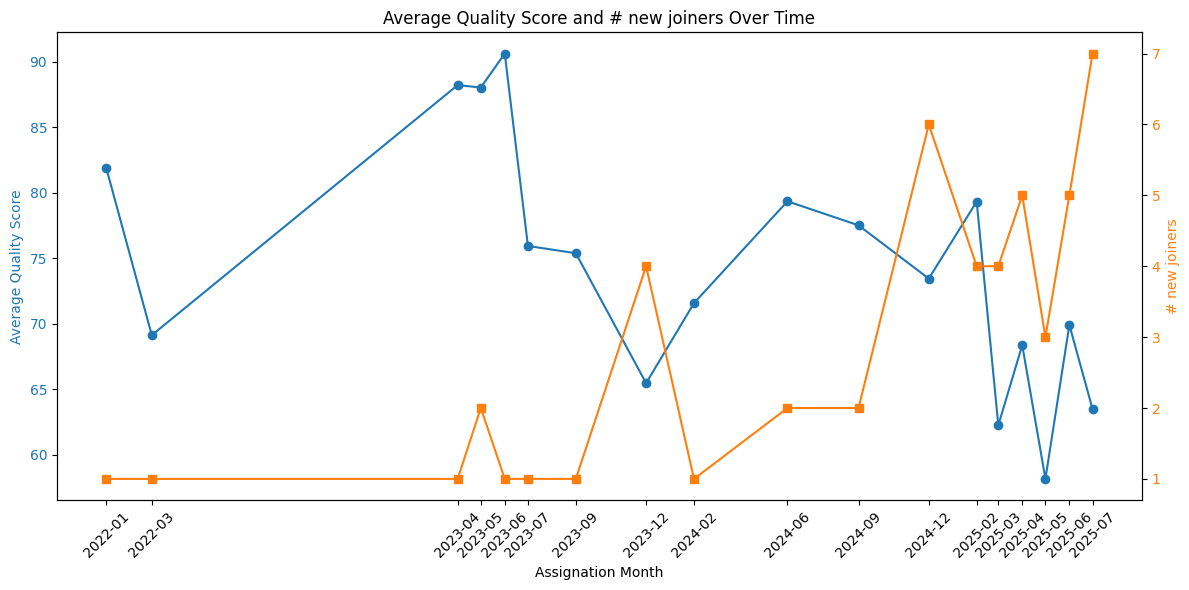

In [14]:
# Get all unique months where there is at least one data point
months_quality = set(monthly_quality_std['assignation_month'])
months_assignees = set(monthly_unique_assignees['assignation_month'])
all_months_with_data = sorted(list(months_quality.union(months_assignees)))

fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:blue'
ax1.set_xlabel('Assignation Month')
ax1.set_ylabel('Average Quality Score', color=color)
ax1.plot(monthly_quality_std['assignation_month'], monthly_quality_std['quality_score_std'], marker='o', color=color, label='Avg Quality Score')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:orange'
ax2.set_ylabel('# new joiners', color=color)
ax2.plot(monthly_unique_assignees['assignation_month'], monthly_unique_assignees['unique_assignees'], marker='s', color=color, label='Unique Assignees')
ax2.tick_params(axis='y', labelcolor=color)

# Set x-ticks to only the months where there is a data point
ax1.set_xticks(all_months_with_data)
ax1.set_xticklabels([pd.to_datetime(m).strftime('%Y-%m') for m in all_months_with_data], rotation=45)

plt.title('Average Quality Score and # new joiners Over Time')
fig.tight_layout()
plt.show()


## 2. Leads:

In [15]:
# Filter leads
leads = df[df['lead_or_account'] == 'lead'].copy()
lead_cols = ['days_last_car_view']

# Calculate days since last login and creation (relative to today)
today = pd.Timestamp.today()
leads['days_since_last_login'] = (today - leads['last_login_date']).dt.days
leads['days_since_creation'] = (today - leads['creation_date']).dt.days

# Add these to columns for summary
lead_cols += ['days_since_last_login', 'days_since_creation']

# Calculate summary stats
summary_leads = leads[lead_cols].agg(['mean', 'median', 'std', 'min', 'max']).T
summary_leads['missing'] = leads[lead_cols].isnull().sum()

print("Leads - Key Statistics:")
display(summary_leads)


Leads - Key Statistics:


,mean,median,std,min,max,missing
days_last_car_view,823.361169,520.0,844.728081,1.0,3212.0,69
days_since_last_login,765.963905,395.0,829.655471,7.0,3456.0,43
days_since_creation,1719.037113,1566.0,1066.972422,14.0,3976.0,0


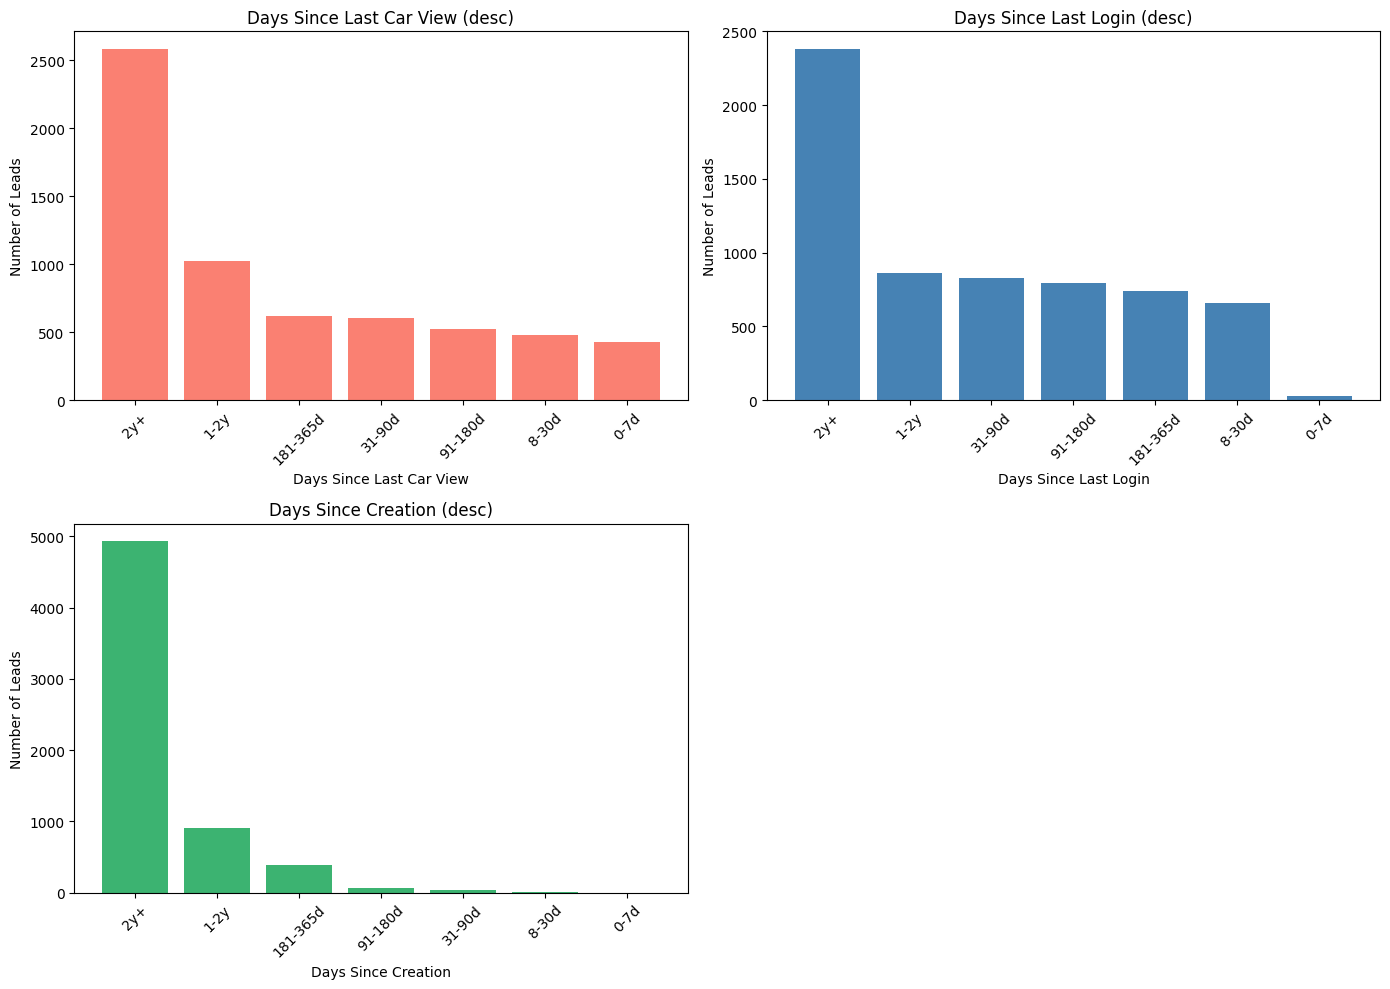

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1. Days since last car view
bins_view = [0, 7, 30, 90, 180, 365, 730, np.inf]
labels_view = ['0-7d', '8-30d', '31-90d', '91-180d', '181-365d', '1-2y', '2y+']
leads['view_bin'] = pd.cut(leads['days_last_car_view'], bins=bins_view, labels=labels_view, right=True, include_lowest=True)
bin_counts = leads['view_bin'].value_counts().sort_values(ascending=False)
axes[0, 0].bar(bin_counts.index, bin_counts.values, color='salmon')
axes[0, 0].set_title('Days Since Last Car View (desc)')
axes[0, 0].set_ylabel('Number of Leads')
axes[0, 0].set_xlabel('Days Since Last Car View')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Days since last login
bins_login = [0, 7, 30, 90, 180, 365, 730, np.inf]
labels_login = ['0-7d', '8-30d', '31-90d', '91-180d', '181-365d', '1-2y', '2y+']
leads['login_bin'] = pd.cut(leads['days_since_last_login'], bins=bins_login, labels=labels_login, right=True, include_lowest=True)
bin_counts = leads['login_bin'].value_counts().sort_values(ascending=False)
axes[0, 1].bar(bin_counts.index, bin_counts.values, color='steelblue')
axes[0, 1].set_title('Days Since Last Login (desc)')
axes[0, 1].set_ylabel('Number of Leads')
axes[0, 1].set_xlabel('Days Since Last Login')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Days since creation
bins_creation = [0, 7, 30, 90, 180, 365, 730, np.inf]
labels_creation = ['0-7d', '8-30d', '31-90d', '91-180d', '181-365d', '1-2y', '2y+']
leads['creation_bin'] = pd.cut(leads['days_since_creation'], bins=bins_creation, labels=labels_creation, right=True, include_lowest=True)
bin_counts = leads['creation_bin'].value_counts().sort_values(ascending=False)
axes[1, 0].bar(bin_counts.index, bin_counts.values, color='mediumseagreen')
axes[1, 0].set_title('Days Since Creation (desc)')
axes[1, 0].set_ylabel('Number of Leads')
axes[1, 0].set_xlabel('Days Since Creation')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Placeholder for a 4th plot (can use another feature or leave blank)
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()




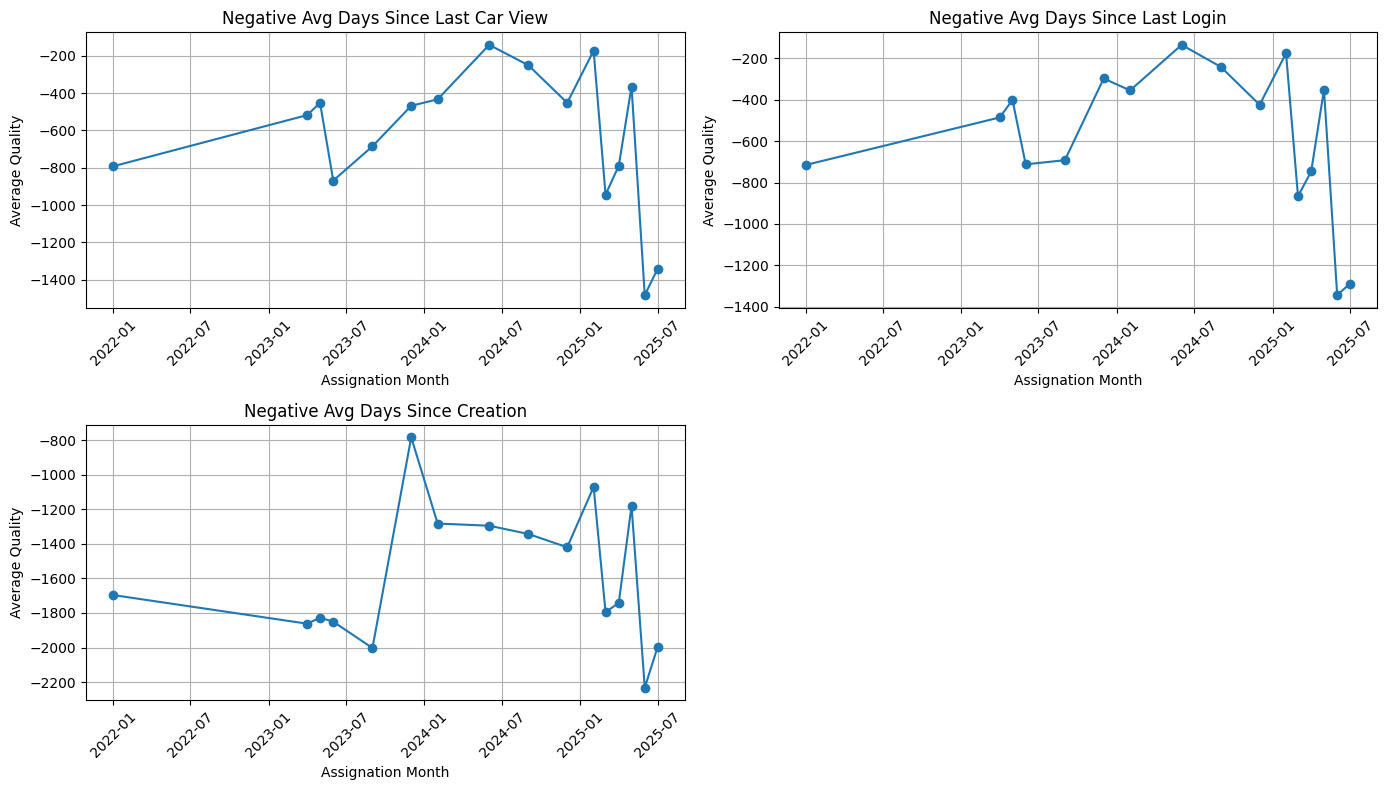

In [17]:
# List of features to plot over time
features = [
    ('days_last_car_view', 'Avg Days Since Last Car View'),
    ('days_since_last_login', 'Avg Days Since Last Login'),
    ('days_since_creation', 'Avg Days Since Creation')
]

# Group by assignation_month and calculate mean for each feature
monthly_stats_leads = leads.groupby('assignation_month')[
    [f[0] for f in features]
].mean().reset_index()

# Set up grid size
n_features = len(features)
n_cols = 2
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharex=False)
axes = axes.flatten()  # Flatten in case of 2D array

for i, (col, label) in enumerate(features):
    axes[i].plot(monthly_stats_leads['assignation_month'], -1 * monthly_stats_leads[col], marker='o')
    axes[i].set_title(f'Negative {label}')
    axes[i].set_ylabel('Average Quality')
    axes[i].set_xlabel('Assignation Month')
    axes[i].grid(True)
    for tick in axes[i].get_xticklabels():
        tick.set_rotation(45)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


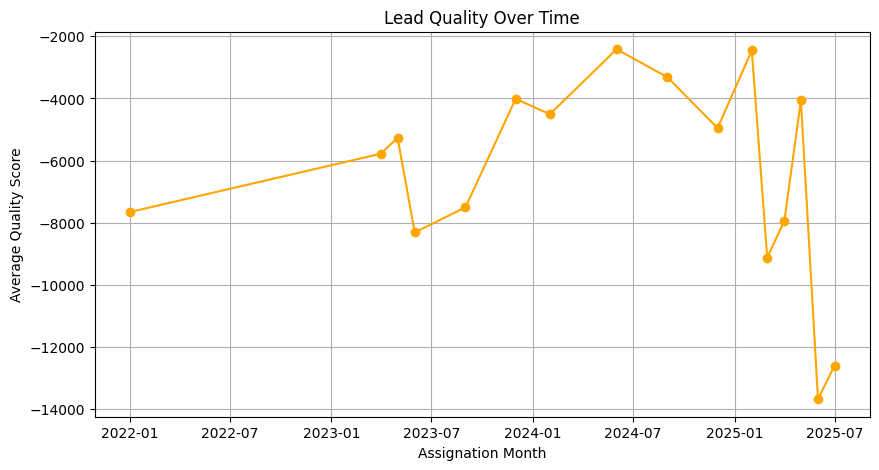

In [18]:

# Calculate quality score for leads
def lead_quality(row):
    score = 0
    score -= row.get('days_last_car_view', 0) * 5
    score -= row.get('days_since_last_login', 0) * 3
    score -= row.get('days_since_creation', 0) * 1
    return score

leads['quality_score'] = leads.apply(lead_quality, axis=1)

# Aggregate average quality by assignation_month
monthly_quality_leads = leads.groupby('assignation_month')['quality_score'].mean().reset_index()

# Plot
plt.figure(figsize=(10,5))
plt.plot(monthly_quality_leads['assignation_month'], monthly_quality_leads['quality_score'], marker='o', color='orange')
plt.title('Lead Quality Over Time')
plt.xlabel('Assignation Month')
plt.ylabel('Average Quality Score')
plt.grid(True)
plt.show()



In [19]:
#standardization of the quality score
min_score = leads['quality_score'].min()
max_score = leads['quality_score'].max()
if max_score > min_score:
    leads['quality_score_std'] = 100 * (leads['quality_score'] - min_score) / (max_score - min_score)
else:
    leads['quality_score_std'] = 50  # fallback if all scores are equal

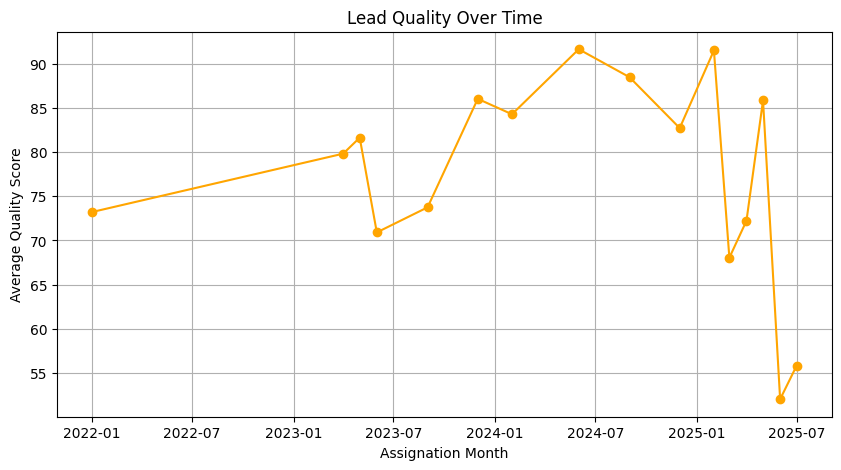

In [20]:
# Aggregate average quality by assignation_month
monthly_quality_leads_std = leads.groupby('assignation_month')['quality_score_std'].mean().reset_index()

# Plot
plt.figure(figsize=(10,5))
plt.plot(monthly_quality_leads_std['assignation_month'], monthly_quality_leads_std['quality_score_std'], marker='o', color='orange')
plt.title('Lead Quality Over Time')
plt.xlabel('Assignation Month')
plt.ylabel('Average Quality Score')
plt.grid(True)
plt.show()


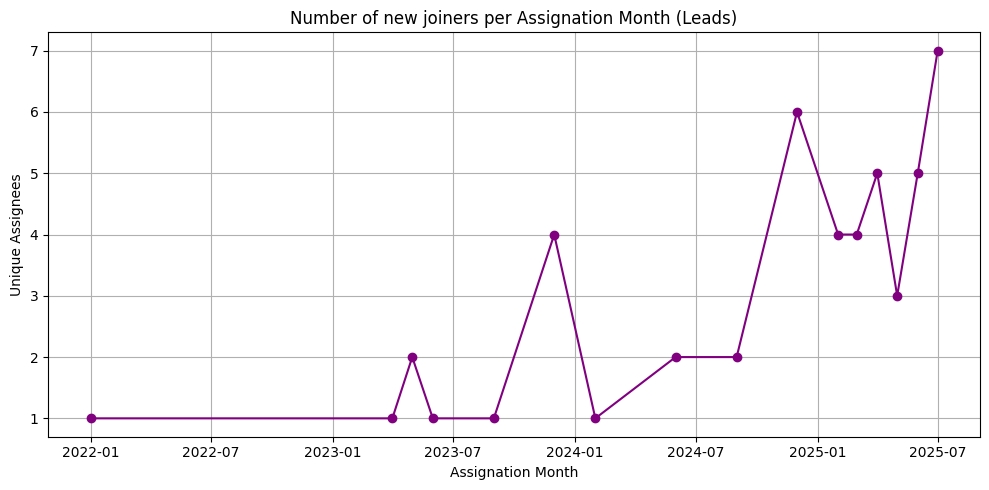

In [21]:
# For leads, count unique assignees per assignation month
monthly_unique_assignees_leads = (
    leads.groupby('assignation_month')['assignee']
    .nunique()
    .reset_index(name='unique_assignees')
)

plt.figure(figsize=(10,5))
plt.plot(monthly_unique_assignees_leads['assignation_month'], monthly_unique_assignees_leads['unique_assignees'], marker='o', color='purple')
plt.title('Number of new joiners per Assignation Month (Leads)')
plt.xlabel('Assignation Month')
plt.ylabel('Unique Assignees')
plt.grid(True)
plt.tight_layout()
plt.show()


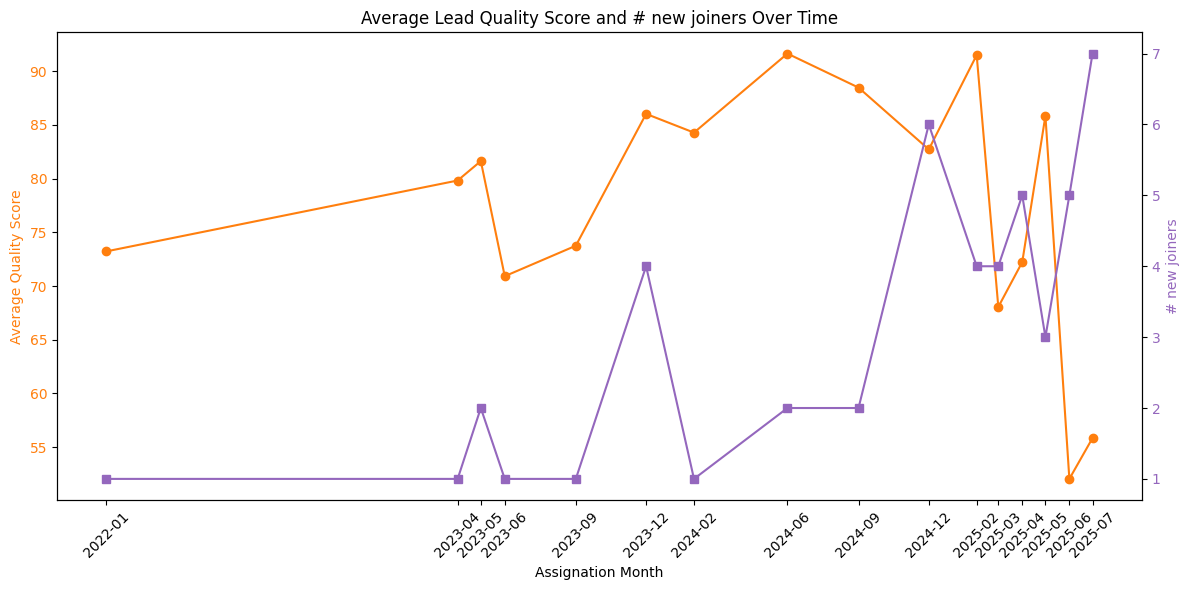

In [22]:
# Get all unique months where there is at least one data point
months_quality = set(monthly_quality_leads_std['assignation_month'])
months_assignees = set(monthly_unique_assignees_leads['assignation_month'])
all_months_with_data = sorted(list(months_quality.union(months_assignees)))

fig, ax1 = plt.subplots(figsize=(12,6))

color = 'tab:orange'
ax1.set_xlabel('Assignation Month')
ax1.set_ylabel('Average Quality Score', color=color)
ax1.plot(
    monthly_quality_leads_std['assignation_month'],
    monthly_quality_leads_std['quality_score_std'],
    marker='o', color=color, label='Avg Quality Score'
)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:purple'
ax2.set_ylabel('# new joiners', color=color)
ax2.plot(
    monthly_unique_assignees_leads['assignation_month'],
    monthly_unique_assignees_leads['unique_assignees']
,
    marker='s', color=color, label='Unique Assignees'
)
ax2.tick_params(axis='y', labelcolor=color)

# Set x-ticks to only the months where there is a data point
ax1.set_xticks(all_months_with_data)
ax1.set_xticklabels([pd.to_datetime(m).strftime('%Y-%m') for m in all_months_with_data], rotation=45)

plt.title('Average Lead Quality Score and # new joiners Over Time')
fig.tight_layout()
plt.show()


## 3) Evolution of Leads/ Accounts

In [24]:
# Count number of accounts assigned per month
monthly_accounts_assigned = (
    accounts.groupby('assignation_month')['merchant_id']
    .nunique()
    .reset_index(name='accounts_assigned')
)

# Count number of leads assigned per month
monthly_leads_assigned = (
    leads.groupby('assignation_month')['merchant_id']
    .nunique()
    .reset_index(name='leads_assigned')
)

# Merge for combined table and plot
monthly_assignments = pd.merge(
    monthly_accounts_assigned,
    monthly_leads_assigned,
    on='assignation_month',
    how='outer'
).sort_values('assignation_month')

monthly_assignments = monthly_assignments.fillna(0)


# Print the numbers as a table
print("\nNumber of Accounts and Leads Assigned per Assignation Month:")
print(monthly_assignments)



Number of Accounts and Leads Assigned per Assignation Month:
   assignation_month  accounts_assigned  leads_assigned
0         2022-01-01                 74           198.0
1         2022-03-01                  7             0.0
2         2023-04-01                 28           201.0
3         2023-05-01                 69           390.0
4         2023-06-01                  6           153.0
5         2023-07-01                196             0.0
6         2023-09-01                190             1.0
7         2023-12-01                763             6.0
8         2024-02-01                169            91.0
9         2024-06-01                384           200.0
10        2024-09-01                385           216.0
11        2024-12-01                844           691.0
12        2025-02-01                660           501.0
13        2025-03-01                437           437.0
14        2025-04-01                619           836.0
15        2025-05-01                339   

In [25]:
# Number of unique assignees per month (new joiners)
monthly_new_joiners = (
    df.groupby('assignation_month')['assignee']
    .nunique()
    .reset_index(name='new_joiners')
)

# Merge with assignments
monthly_assignments_with_joiners = pd.merge(
    monthly_assignments,
    monthly_new_joiners,
    on='assignation_month',
    how='left'
)

# Compute averages
monthly_avg = monthly_assignments_with_joiners.copy()
monthly_avg['avg_accounts_per_new_joiner'] = monthly_avg['accounts_assigned'] / monthly_avg['new_joiners']
monthly_avg['avg_leads_per_new_joiner'] = monthly_avg['leads_assigned'] / monthly_avg['new_joiners']


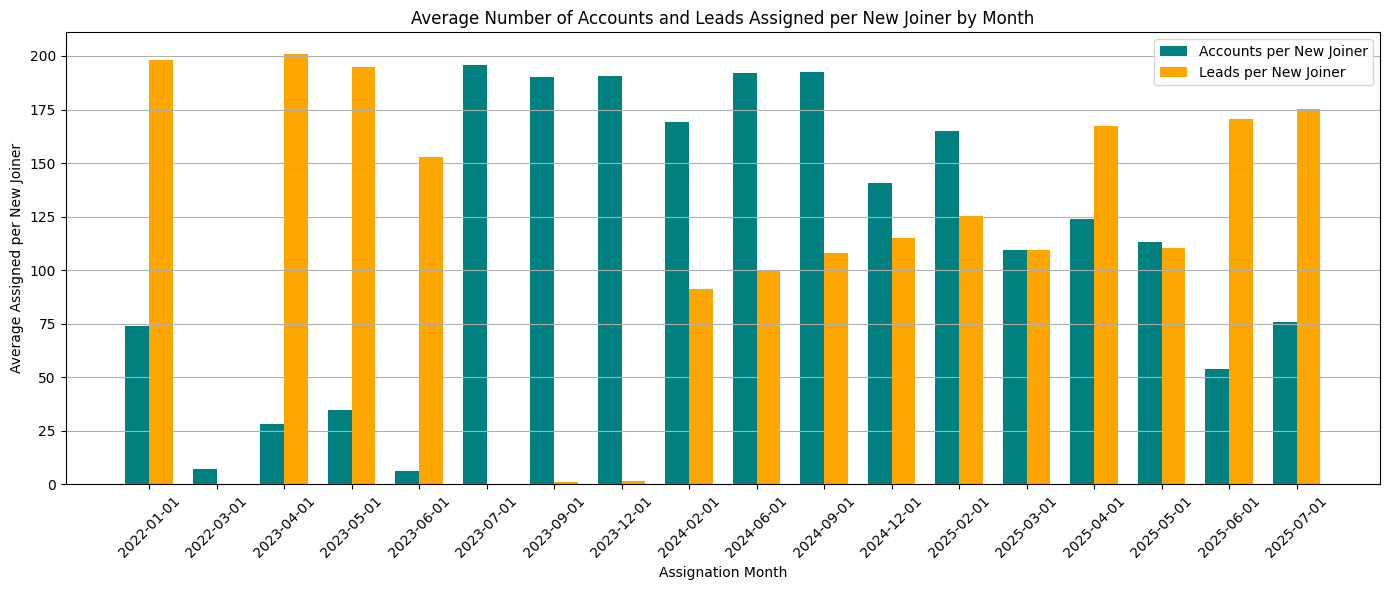

In [26]:
# Prepare data
labels = monthly_avg['assignation_month'].astype(str)
accounts_means = monthly_avg['avg_accounts_per_new_joiner']
leads_means = monthly_avg['avg_leads_per_new_joiner']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14,6))
rects1 = ax.bar(x - width/2, accounts_means, width, label='Accounts per New Joiner', color='teal')
rects2 = ax.bar(x + width/2, leads_means, width, label='Leads per New Joiner', color='orange')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Assignation Month')
ax.set_ylabel('Average Assigned per New Joiner')
ax.set_title('Average Number of Accounts and Leads Assigned per New Joiner by Month')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
ax.grid(axis='y')

fig.tight_layout()
plt.show()


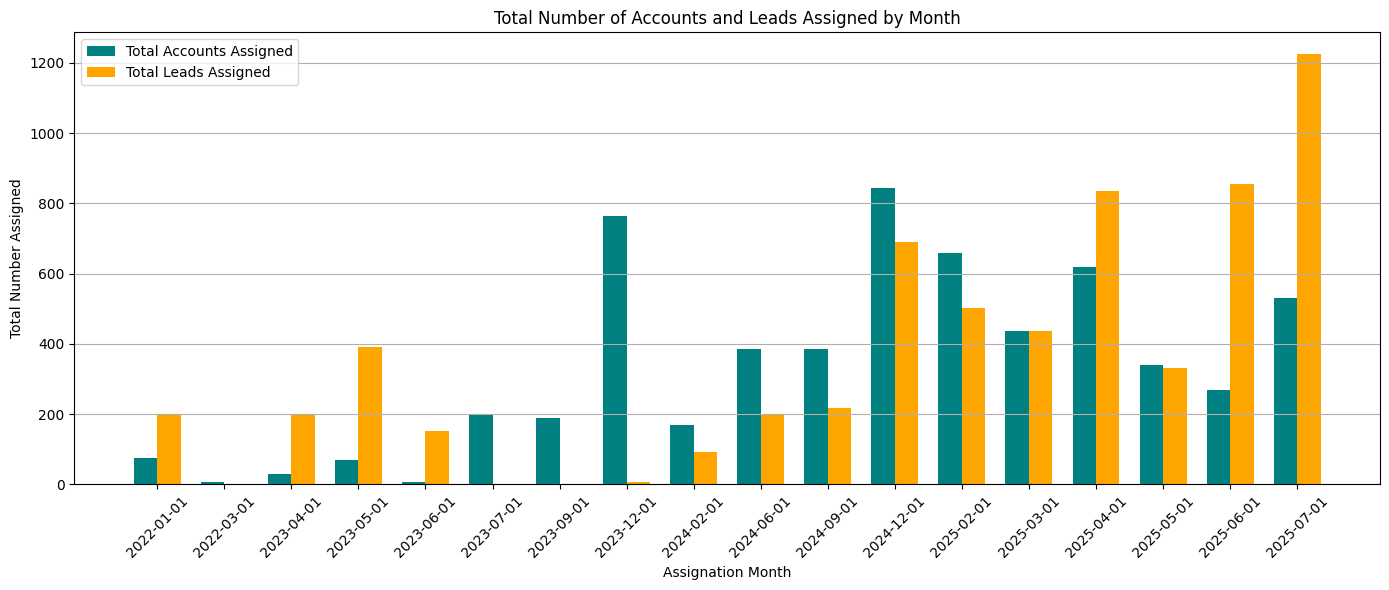

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data
labels = monthly_avg['assignation_month'].astype(str)
accounts_totals = monthly_avg['accounts_assigned']
leads_totals = monthly_avg['leads_assigned']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14,6))
rects1 = ax.bar(x - width/2, accounts_totals, width, label='Total Accounts Assigned', color='teal')
rects2 = ax.bar(x + width/2, leads_totals, width, label='Total Leads Assigned', color='orange')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Assignation Month')
ax.set_ylabel('Total Number Assigned')
ax.set_title('Total Number of Accounts and Leads Assigned by Month')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
ax.grid(axis='y')

fig.tight_layout()
plt.show()


In [29]:
# monthly_avg['avg_accounts_per_new_joiner_interp'] = monthly_avg['avg_accounts_per_new_joiner'].interpolate()
# monthly_avg['avg_leads_per_new_joiner_interp'] = monthly_avg['avg_leads_per_new_joiner'].interpolate()

# plt.figure(figsize=(12,6))
# plt.plot(monthly_avg['assignation_month'], monthly_avg['avg_accounts_per_new_joiner_interp'], marker='o', label='Accounts per New Joiner')
# plt.plot(monthly_avg['assignation_month'], monthly_avg['avg_leads_per_new_joiner_interp'], marker='s', label='Leads per New Joiner')
# plt.title('Average Number of Accounts/Leads Assigned per New Joiner Over Time')
# plt.xlabel('Assignation Month')
# plt.ylabel('Average Assigned per New Joiner')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


## 4) Current Dealer Base

In [30]:
df = pd.read_csv('Accounts Quality Assessment  - Accounts + Leads DB.csv')

# Remove banned accounts
df_clean = df[df['banned_date'].isna()].copy()
pf_size=250

In [36]:
print(f'Total number of merchants in the dealer base: {len(df)}')

Total number of merchants in the dealer base: 9789


In [35]:
print(f'Number of merchants that are not banned: {len(df_clean)}')

Number of Merchants that are not banned: 4532


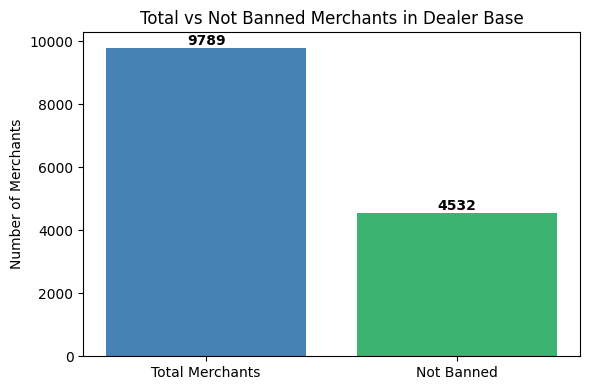

In [66]:

labels = ['Total Merchants', 'Not Banned']
counts = [len(df), len(df_clean)]

# Plot
plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=['steelblue', 'mediumseagreen'])
plt.ylabel('Number of Merchants')
plt.title('Total vs Not Banned Merchants in Dealer Base')
for i, v in enumerate(counts):
    plt.text(i, v + max(counts)*0.01, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()


In [31]:
current_accounts = df_clean[df_clean['lead_or_account'] == 'account']
current_leads = df_clean[df_clean['lead_or_account'] == 'lead']


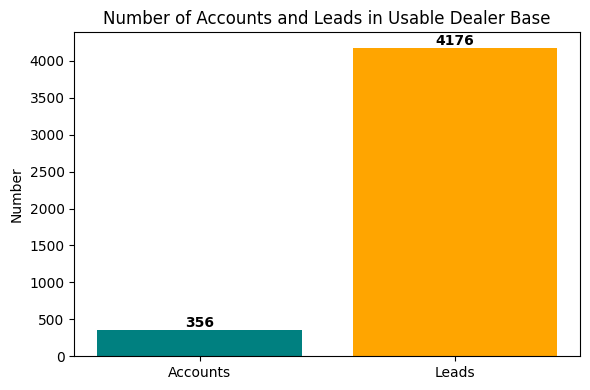

In [67]:
nb_accounts = len(current_accounts)
nb_leads = len(current_leads)

# Data for plotting
labels = ['Accounts', 'Leads']
counts = [nb_accounts, nb_leads]

# Plot
plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=['teal', 'orange'])
plt.ylabel('Number')
plt.title('Number of Accounts and Leads in Usable Dealer Base')
for i, v in enumerate(counts):
    plt.text(i, v + max(counts)*0.01, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()


In [32]:
num_pf_by_accounts = len(current_accounts) // 50
num_pf_by_total = len(df_clean) // 250
num_portfolios = min(num_pf_by_accounts, num_pf_by_total)
print(f"Number of portfolios possible with 50 accounts and 200 leads: {num_portfolios}")


Number of portfolios possible with 50 accounts and 200 leads: 7


In [33]:
portfolios = []
accounts_shuffled = current_accounts.sample(frac=1, random_state=42).reset_index(drop=True)
leads_shuffled = leads.sample(frac=1, random_state=42).reset_index(drop=True)

for i in range(num_portfolios):
    pf_accounts = accounts_shuffled.iloc[i*50:(i+1)*50]
    pf_leads = leads_shuffled.iloc[i*(250-50):(i+1)*(250-50)]
    pf = pd.concat([pf_accounts, pf_leads])
    portfolios.append(pf)


In [34]:
portfolios_avg_ncs = []
for i, pf in enumerate(portfolios):
    avg_quality = pf['ncs_alltime'].mean()
    portfolios_avg_ncs.append({'portfolio': i+1, 'avg_ncs_alltime': avg_quality})

quality_df = pd.DataFrame(portfolios_avg_ncs)
print(quality_df)


   portfolio  avg_ncs_alltime
0          1        14.220000
1          2         6.196078
2          3         8.549020
3          4         6.300000
4          5         7.160000
5          6         3.921569
6          7         8.020000


In [37]:
df_clean['last_login_date'] = pd.to_datetime(df_clean['last_login_date'], errors='coerce')
df_clean['creation_date'] = pd.to_datetime(df_clean['creation_date'], errors='coerce')


In [38]:
today = pd.Timestamp.today()
df_clean['days_since_last_login'] = (today - df_clean['last_login_date']).dt.days
df_clean['days_since_creation'] = (today - df_clean['creation_date']).dt.days


In [39]:
# Calculate days_since_last_login and days_since_creation for all rows (needed for leads)
today = pd.Timestamp.today()
df_clean['days_since_last_login'] = (today - df_clean['last_login_date']).dt.days
df_clean['days_since_creation'] = (today - df_clean['creation_date']).dt.days

# Apply the correct quality function for each row
df_clean['quality_score'] = np.where(
    df_clean['lead_or_account'] == 'account',
    df_clean.apply(account_quality, axis=1),
    df_clean.apply(lead_quality, axis=1)
)

In [40]:
min_score = df_clean['quality_score'].min()
max_score = df_clean['quality_score'].max()
if max_score > min_score:
    df_clean['quality_score_std'] = 100 * (df_clean['quality_score'] - min_score) / (max_score - min_score)
else:
    df_clean['quality_score_std'] = 50  # fallback if all scores are equal


In [41]:
current_accounts = df_clean[df_clean['lead_or_account'] == 'account']
current_leads = df_clean[df_clean['lead_or_account'] == 'lead']

accounts_shuffled = current_accounts.sample(frac=1, random_state=42).reset_index(drop=True)
leads_shuffled = current_leads.sample(frac=1, random_state=42).reset_index(drop=True)


In [42]:
portfolios = []
for i in range(num_portfolios):
    pf_accounts = accounts_shuffled.iloc[i*50:(i+1)*50]
    pf_leads = leads_shuffled.iloc[i*(pf_size-50):(i+1)*(pf_size-50)]
    pf = pd.concat([pf_accounts, pf_leads])
    portfolios.append(pf)

portfolios_stats = []
for i, pf in enumerate(portfolios):
    pf_accounts = pf[pf['lead_or_account'] == 'account']
    pf_leads = pf[pf['lead_or_account'] == 'lead']
    avg_quality_accounts = pf_accounts['quality_score_std'].mean() if not pf_accounts.empty else np.nan
    avg_quality_leads = pf_leads['quality_score_std'].mean() if not pf_leads.empty else np.nan
    portfolios_stats.append({
        'portfolio': i+1,
        'nb_accounts': len(pf_accounts),
        'nb_leads': len(pf_leads),
        'avg_quality_accounts': avg_quality_accounts,
        'avg_quality_leads': avg_quality_leads
    })

portfolios_stats_df = pd.DataFrame(portfolios_stats)
print(portfolios_stats_df)


   portfolio  nb_accounts  nb_leads  avg_quality_accounts  avg_quality_leads
0          1           50       200             40.268799          61.435167
1          2           50       200             41.463526          55.436022
2          3           50       200             38.235786          54.428937
3          4           50       200             32.313058          51.795873
4          5           50       200             41.885916          59.405574
5          6           50       200             34.272407          42.120328
6          7           50       200             39.086082          46.157732


In [43]:
# Calculate the number of leads already used in the mixed portfolios
leads_used = num_portfolios * (pf_size - 50)
remaining_leads = leads_shuffled.iloc[leads_used:].reset_index(drop=True)


In [44]:
num_leads_only_pfs = len(remaining_leads) // pf_size

leads_only_portfolios = []
for i in range(num_leads_only_pfs):
    pf_leads = remaining_leads.iloc[i*pf_size:(i+1)*pf_size]
    leads_only_portfolios.append(pf_leads)


In [45]:
leads_only_stats = []
for i, pf in enumerate(leads_only_portfolios):
    avg_quality_leads = pf['quality_score_std'].mean() if not pf.empty else np.nan
    leads_only_stats.append({
        'portfolio': i+1+num_portfolios,  # continue numbering after mixed portfolios
        'nb_accounts': 0,
        'nb_leads': len(pf),
        'avg_quality_accounts': np.nan,
        'avg_quality_leads': avg_quality_leads
    })

leads_only_stats_df = pd.DataFrame(leads_only_stats)
print(leads_only_stats_df)


    portfolio  nb_accounts  nb_leads  avg_quality_accounts  avg_quality_leads
0           8            0       250                   NaN          56.951767
1           9            0       250                   NaN          49.085152
2          10            0       250                   NaN          49.721880
3          11            0       250                   NaN          52.866492
4          12            0       250                   NaN          51.960522
5          13            0       250                   NaN          63.845080
6          14            0       250                   NaN          66.017075
7          15            0       250                   NaN          58.181545
8          16            0       250                   NaN          61.790364
9          17            0       250                   NaN          59.301814
10         18            0       250                   NaN          54.492232


In [46]:
all_portfolios_df = pd.concat([portfolios_stats_df, leads_only_stats_df], ignore_index=True)
print(all_portfolios_df)


    portfolio  nb_accounts  nb_leads  avg_quality_accounts  avg_quality_leads
0           1           50       200             40.268799          61.435167
1           2           50       200             41.463526          55.436022
2           3           50       200             38.235786          54.428937
3           4           50       200             32.313058          51.795873
4           5           50       200             41.885916          59.405574
5           6           50       200             34.272407          42.120328
6           7           50       200             39.086082          46.157732
7           8            0       250                   NaN          56.951767
8           9            0       250                   NaN          49.085152
9          10            0       250                   NaN          49.721880
10         11            0       250                   NaN          52.866492
11         12            0       250                   NaN      

In [56]:
nb_accounts_future = all_portfolios_df['nb_accounts'].sum()
nb_leads_future = all_portfolios_df['nb_leads'].sum()
future_new_joiners = len(all_portfolios_df)


In [57]:
future_row = {
    'assignation_month': 'Future Rotation Dealer Base',
    'accounts_assigned': nb_accounts_future,
    'leads_assigned': nb_leads_future
}

monthly_assignments_with_future = pd.concat([
    monthly_assignments,
    pd.DataFrame([future_row])
], ignore_index=True)


In [61]:
future_new_joiners = num_leads_only_pfs + num_portfolios  # or num_portfolios if you want all portfolios


In [63]:
future_avg_row = {
    'assignation_month': 'Future Rotation Dealer Base',
    'accounts_assigned': nb_accounts_future,
    'leads_assigned': nb_leads_future,
    'new_joiners': future_new_joiners,
    'avg_accounts_per_new_joiner': nb_accounts_future / future_new_joiners if future_new_joiners else np.nan,
    'avg_leads_per_new_joiner': nb_leads_future / future_new_joiners if future_new_joiners else np.nan
}

monthly_avg_with_future = pd.concat([
    monthly_avg,
    pd.DataFrame([future_avg_row])
], ignore_index=True)


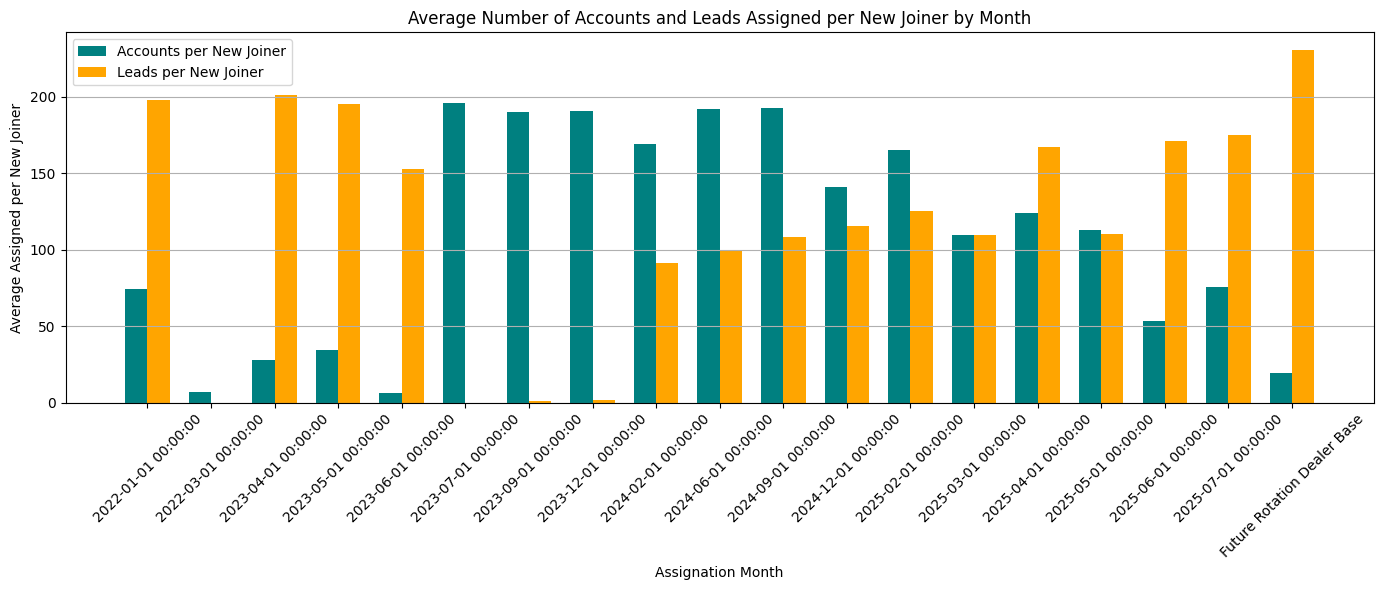

In [64]:
labels = monthly_avg_with_future['assignation_month'].astype(str)
accounts_means = monthly_avg_with_future['avg_accounts_per_new_joiner']
leads_means = monthly_avg_with_future['avg_leads_per_new_joiner']

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(14,6))
rects1 = ax.bar(x - width/2, accounts_means, width, label='Accounts per New Joiner', color='teal')
rects2 = ax.bar(x + width/2, leads_means, width, label='Leads per New Joiner', color='orange')

ax.set_xlabel('Assignation Month')
ax.set_ylabel('Average Assigned per New Joiner')
ax.set_title('Average Number of Accounts and Leads Assigned per New Joiner by Month')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
ax.grid(axis='y')

fig.tight_layout()
plt.show()


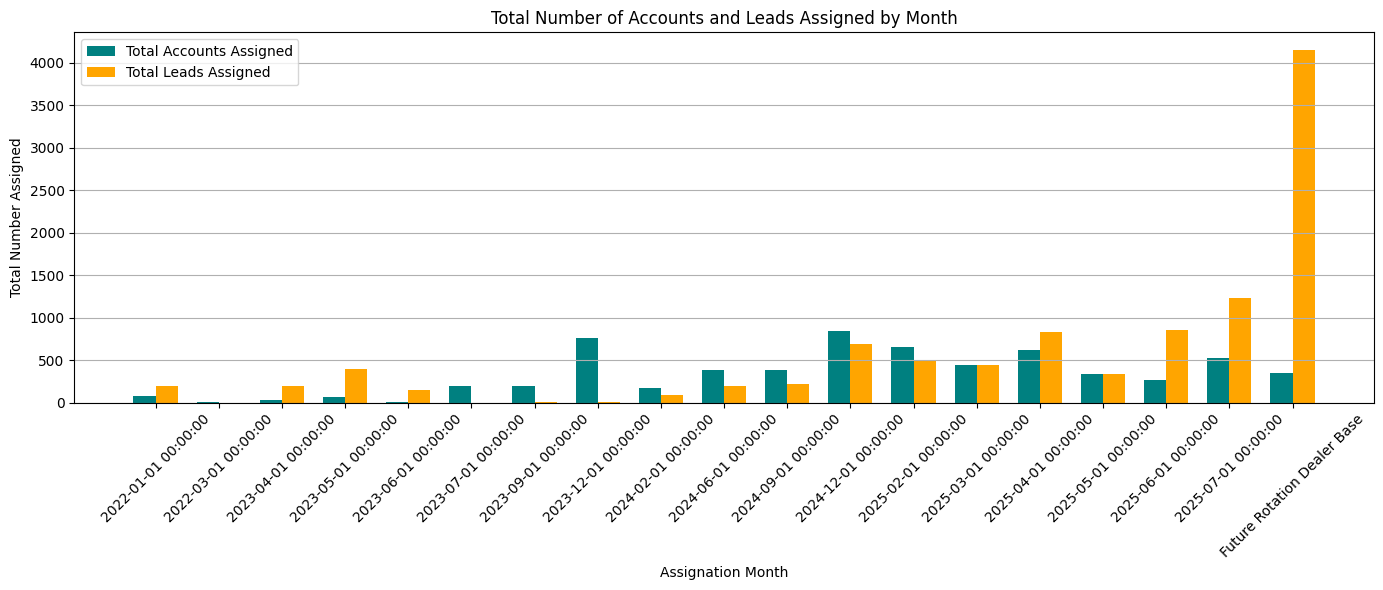

In [65]:
labels = monthly_avg_with_future['assignation_month'].astype(str)
accounts_totals = monthly_avg_with_future['accounts_assigned']
leads_totals = monthly_avg_with_future['leads_assigned']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14,6))
rects1 = ax.bar(x - width/2, accounts_totals, width, label='Total Accounts Assigned', color='teal')
rects2 = ax.bar(x + width/2, leads_totals, width, label='Total Leads Assigned', color='orange')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Assignation Month')
ax.set_ylabel('Total Number Assigned')
ax.set_title('Total Number of Accounts and Leads Assigned by Month')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
ax.grid(axis='y')

fig.tight_layout()
plt.show()

In [68]:
# For accounts
future_avg_account_quality = current_accounts['quality_score_std'].mean()

# For leads
future_avg_lead_quality = current_leads['quality_score_std'].mean()


In [69]:
future_row_accounts = {
    'assignation_month': 'Future Assignation Month',
    'quality_score_std': future_avg_account_quality
}

monthly_quality_std_with_future = pd.concat([
    monthly_quality_std,
    pd.DataFrame([future_row_accounts])
], ignore_index=True)


In [70]:
# If you want to use the standardized quality (recommended for comparison)
monthly_quality_leads_std = leads.groupby('assignation_month')['quality_score_std'].mean().reset_index()

future_row_leads = {
    'assignation_month': 'Future Assignation Month',
    'quality_score_std': future_avg_lead_quality
}

monthly_quality_leads_std_with_future = pd.concat([
    monthly_quality_leads_std,
    pd.DataFrame([future_row_leads])
], ignore_index=True)


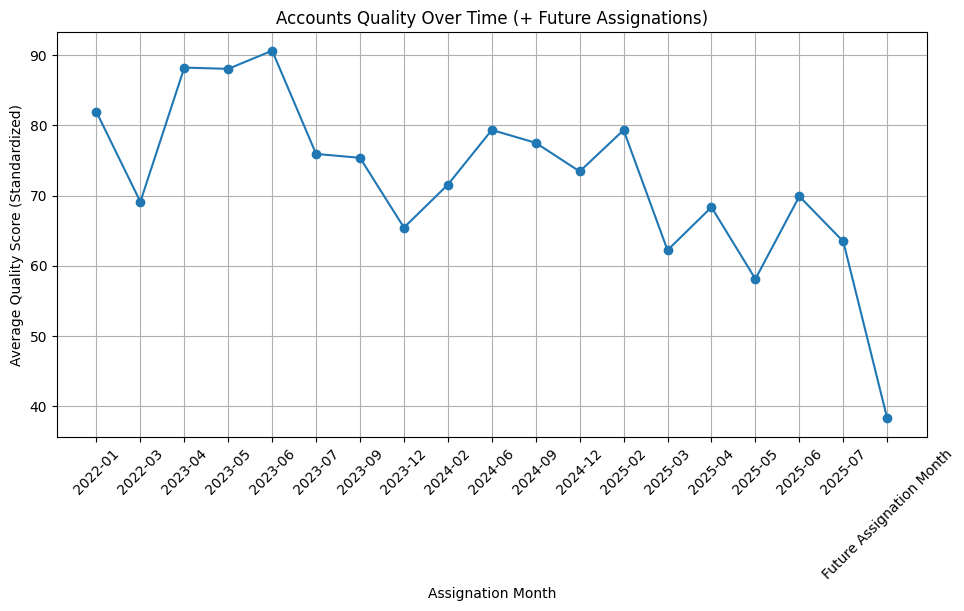

In [82]:
labels = [
    d.strftime('%Y-%m') if not isinstance(d, str) else d
    for d in monthly_quality_std_with_future['assignation_month']
]
plt.figure(figsize=(10,5))
plt.plot(labels, monthly_quality_std_with_future['quality_score_std'], marker='o')
plt.title('Accounts Quality Over Time (+ Future Assignations)')
plt.xlabel('Assignation Month')
plt.ylabel('Average Quality Score (Standardized)')
plt.grid(True)
plt.tight_layout()
plt.tick_params(axis='x', rotation=45)
plt.show()


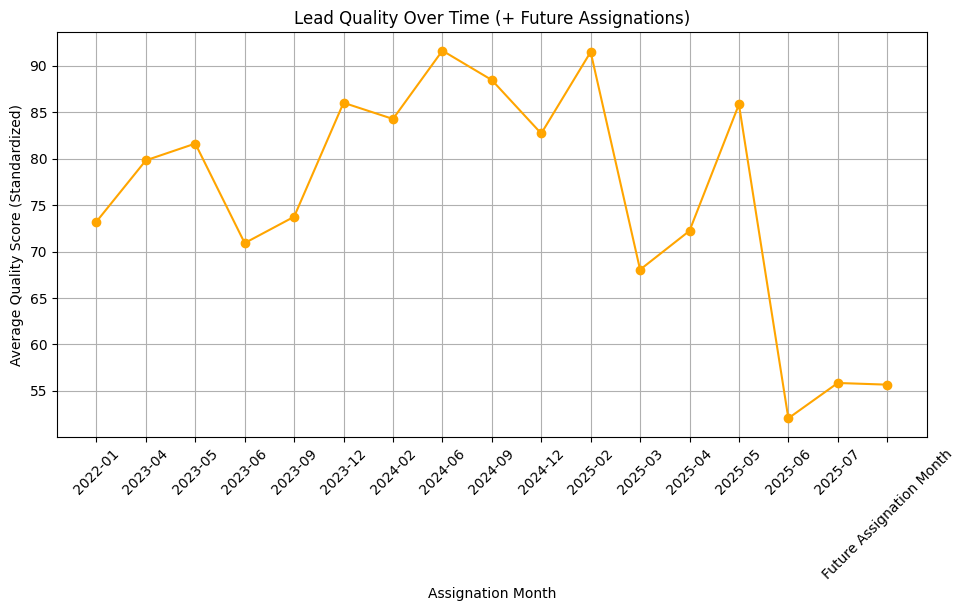

In [83]:
labels = [
    d.strftime('%Y-%m') if not isinstance(d, str) else d
    for d in monthly_quality_leads_std_with_future['assignation_month']
]
plt.figure(figsize=(10,5))
plt.plot(labels, monthly_quality_leads_std_with_future['quality_score_std'], marker='o', color='orange')
plt.title('Lead Quality Over Time (+ Future Assignations)')
plt.xlabel('Assignation Month')
plt.ylabel('Average Quality Score (Standardized)')
plt.grid(True)
plt.tight_layout()
plt.tick_params(axis='x', rotation=45)
plt.show()


## 4) Evolution of Leads/ Accounts

In [48]:
# Count number of accounts assigned per month
monthly_accounts_assigned = (
    accounts.groupby('assignation_month')['merchant_id']
    .nunique()
    .reset_index(name='accounts_assigned')
)

# Count number of leads assigned per month
monthly_leads_assigned = (
    leads.groupby('assignation_month')['merchant_id']
    .nunique()
    .reset_index(name='leads_assigned')
)

# Merge for combined table and plot
monthly_assignments = pd.merge(
    monthly_accounts_assigned,
    monthly_leads_assigned,
    on='assignation_month',
    how='outer'
).sort_values('assignation_month')

monthly_assignments = monthly_assignments.fillna(0)


# Print the numbers as a table
print("\nNumber of Accounts and Leads Assigned per Assignation Month:")
print(monthly_assignments)

# If you use Jupyter Notebook, use display() for a nicer table:
# from IPython.display import display
# display(monthly_assignments)

# # Plot both on the same graph
# plt.figure(figsize=(12,6))
# plt.plot(monthly_assignments['assignation_month'], monthly_assignments['accounts_assigned'], marker='o', label='Accounts Assigned')
# plt.plot(monthly_assignments['assignation_month'], monthly_assignments['leads_assigned'], marker='s', label='Leads Assigned')
# plt.title('Number of Accounts and Leads Assigned to New Joiners Over Time')
# plt.xlabel('Assignation Month')
# plt.ylabel('Number Assigned')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()



Number of Accounts and Leads Assigned per Assignation Month:
   assignation_month  accounts_assigned  leads_assigned
0         2022-01-01                 74           198.0
1         2022-03-01                  7             0.0
2         2023-04-01                 28           201.0
3         2023-05-01                 69           390.0
4         2023-06-01                  6           153.0
5         2023-07-01                196             0.0
6         2023-09-01                190             1.0
7         2023-12-01                763             6.0
8         2024-02-01                169            91.0
9         2024-06-01                384           200.0
10        2024-09-01                385           216.0
11        2024-12-01                844           691.0
12        2025-02-01                660           501.0
13        2025-03-01                437           437.0
14        2025-04-01                619           836.0
15        2025-05-01                339   

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data
labels = monthly_avg['assignation_month'].astype(str)
accounts_means = monthly_avg['avg_accounts_per_new_joiner']
leads_means = monthly_avg['avg_leads_per_new_joiner']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14,6))
rects1 = ax.bar(x - width/2, accounts_means, width, label='Accounts per New Joiner', color='teal')
rects2 = ax.bar(x + width/2, leads_means, width, label='Leads per New Joiner', color='orange')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Assignation Month')
ax.set_ylabel('Average Assigned per New Joiner')
ax.set_title('Average Number of Accounts and Leads Assigned per New Joiner by Month')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
ax.grid(axis='y')

fig.tight_layout()
plt.show()


NameError: name 'monthly_avg' is not defined

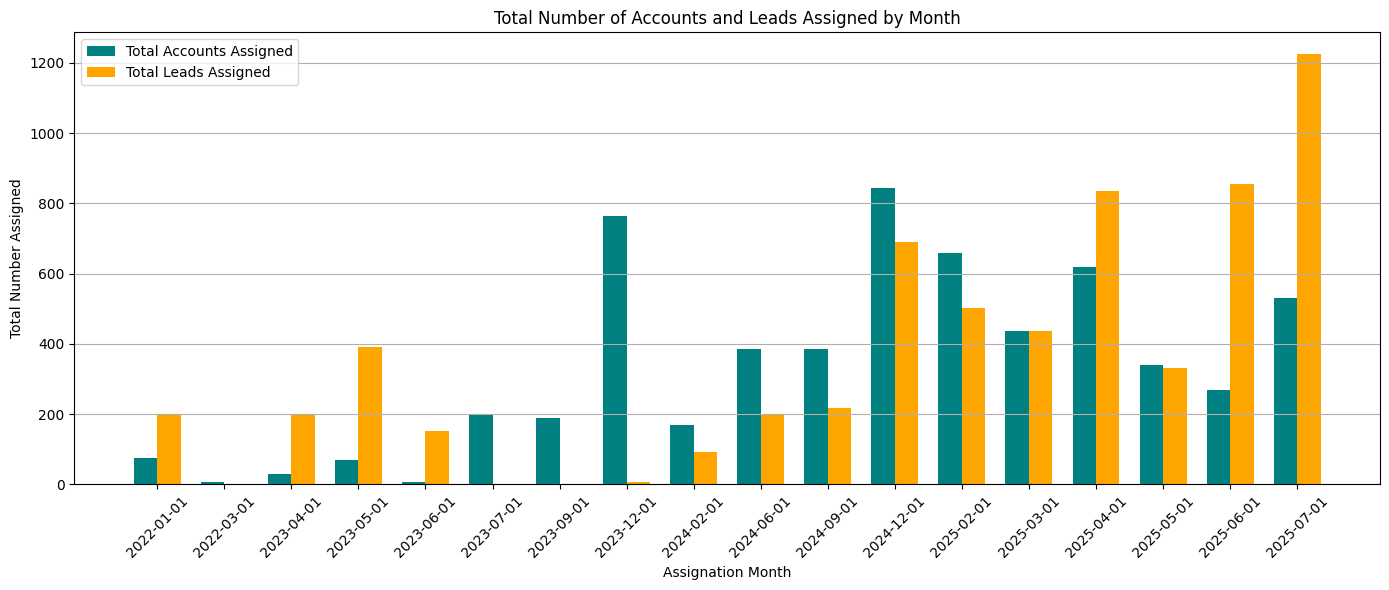

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Prepare data
labels = monthly_avg['assignation_month'].astype(str)
accounts_totals = monthly_avg['accounts_assigned']
leads_totals = monthly_avg['leads_assigned']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(14,6))
rects1 = ax.bar(x - width/2, accounts_totals, width, label='Total Accounts Assigned', color='teal')
rects2 = ax.bar(x + width/2, leads_totals, width, label='Total Leads Assigned', color='orange')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Assignation Month')
ax.set_ylabel('Total Number Assigned')
ax.set_title('Total Number of Accounts and Leads Assigned by Month')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()
ax.grid(axis='y')

fig.tight_layout()
plt.show()


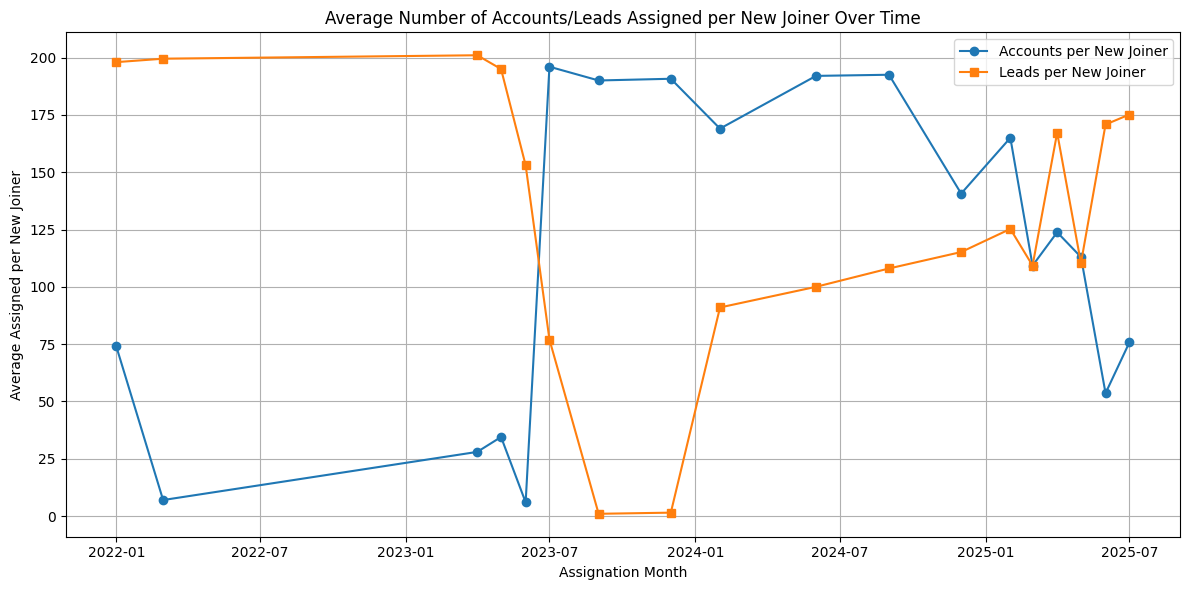

In [ ]:
monthly_avg['avg_accounts_per_new_joiner_interp'] = monthly_avg['avg_accounts_per_new_joiner'].interpolate()
monthly_avg['avg_leads_per_new_joiner_interp'] = monthly_avg['avg_leads_per_new_joiner'].interpolate()

plt.figure(figsize=(12,6))
plt.plot(monthly_avg['assignation_month'], monthly_avg['avg_accounts_per_new_joiner_interp'], marker='o', label='Accounts per New Joiner')
plt.plot(monthly_avg['assignation_month'], monthly_avg['avg_leads_per_new_joiner_interp'], marker='s', label='Leads per New Joiner')
plt.title('Average Number of Accounts/Leads Assigned per New Joiner Over Time')
plt.xlabel('Assignation Month')
plt.ylabel('Average Assigned per New Joiner')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


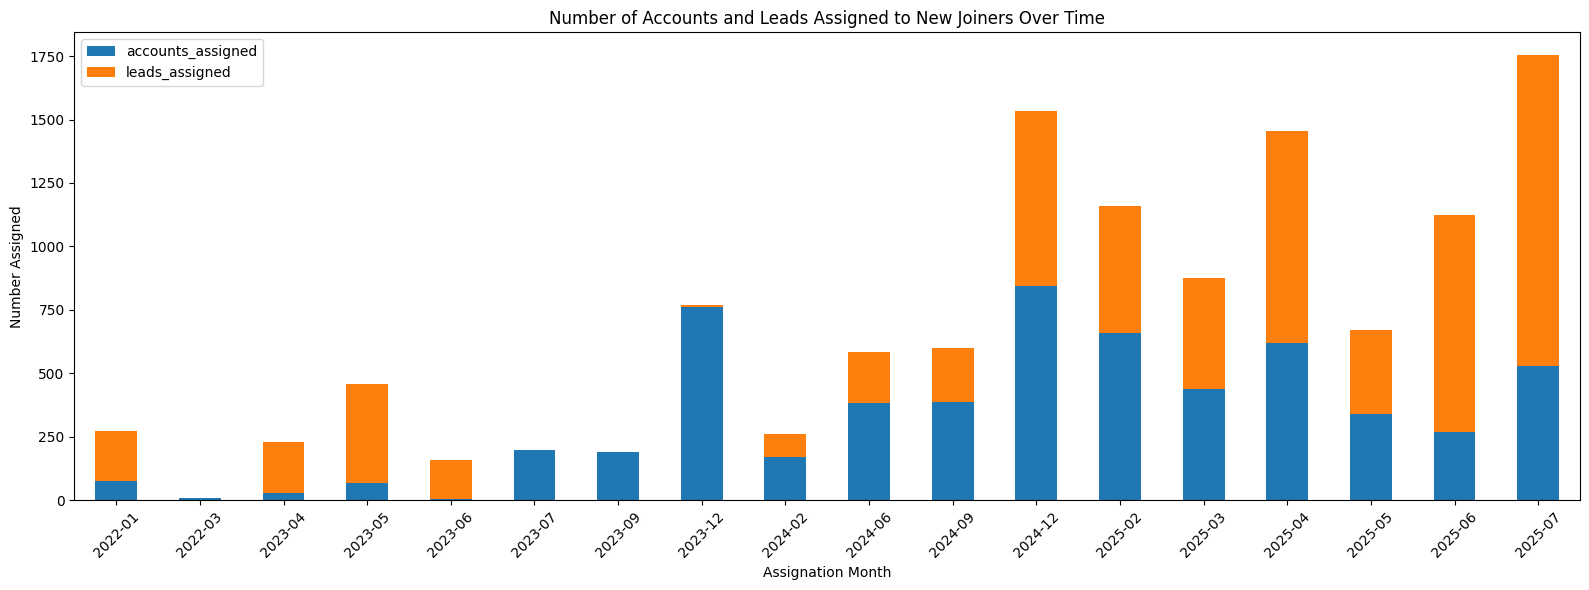

In [ ]:
monthly_assignments['assignation_month'] = pd.to_datetime(monthly_assignments['assignation_month'])

# Create the plot
ax = monthly_assignments.set_index('assignation_month')[['accounts_assigned', 'leads_assigned']].plot(
    kind='bar', stacked=True, figsize=(16,6)
)

plt.title('Number of Accounts and Leads Assigned to New Joiners Over Time')
plt.xlabel('Assignation Month')
plt.ylabel('Number Assigned')

# Format x-tick labels to show only year and month
ax.set_xticklabels([d.strftime('%Y-%m') for d in monthly_assignments['assignation_month']], rotation=45)

plt.tight_layout()
plt.show()


### 3) Units Generated by new joiners

In [ ]:
# For each assignation_month, get the list of new joiners (assignees)
new_joiners = accounts[['assignee', 'assignation_month']].drop_duplicates()

# Merge to get ncs_alltime for each assignee
joiner_ncs = pd.merge(new_joiners, accounts[['assignee', 'ncs_alltime']], on='assignee', how='left')

# Group by assignation_month and sum the ncs_alltime of new joiners
ncs_by_assignation_month = joiner_ncs.groupby('assignation_month')['ncs_alltime'].sum().reset_index()

print(ncs_by_assignation_month)


   assignation_month  ncs_alltime
0         2022-01-01       1690.0
1         2022-03-01        139.0
2         2023-04-01        254.0
3         2023-05-01        644.0
4         2023-06-01         26.0
5         2023-07-01       6879.0
6         2023-09-01       6566.0
7         2023-12-01      13536.0
8         2024-02-01       2875.0
9         2024-06-01       7867.0
10        2024-09-01       5882.0
11        2024-12-01      14501.0
12        2025-02-01       9546.0
13        2025-03-01       5099.0
14        2025-04-01       8621.0
15        2025-05-01       3380.0
16        2025-06-01       3601.0
17        2025-07-01       7334.0


In [ ]:
# 1. List unique new joiners and their assignation month
new_joiners = accounts[['assignee', 'assignation_month']].drop_duplicates()

# 2. Merge to get ncs_alltime for each new joiner
joiner_ncs = pd.merge(new_joiners, accounts[['assignee', 'ncs_alltime']], on='assignee', how='left')

# 3. Group by assignation_month and calculate the average NCS per new joiner
avg_ncs_by_assignation_month = (
    joiner_ncs.groupby('assignation_month')['ncs_alltime']
    .mean()
    .reset_index(name='avg_ncs_per_new_joiner')
)

print(avg_ncs_by_assignation_month)


   assignation_month  avg_ncs_per_new_joiner
0         2022-01-01               22.837838
1         2022-03-01               19.857143
2         2023-04-01                9.071429
3         2023-05-01                9.333333
4         2023-06-01                4.333333
5         2023-07-01               35.096939
6         2023-09-01               34.557895
7         2023-12-01               17.740498
8         2024-02-01               17.011834
9         2024-06-01               20.486979
10        2024-09-01               15.277922
11        2024-12-01               17.181280
12        2025-02-01               14.463636
13        2025-03-01               11.668192
14        2025-04-01               13.927302
15        2025-05-01                9.970501
16        2025-06-01               13.436567
17        2025-07-01               13.837736


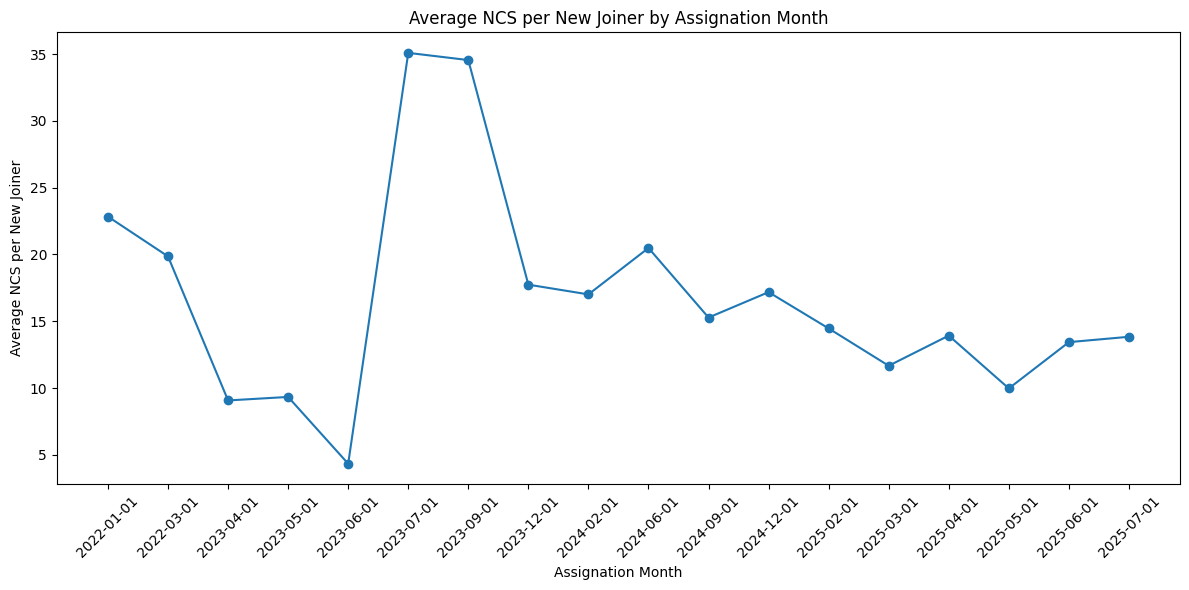

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(avg_ncs_by_assignation_month['assignation_month'].astype(str), avg_ncs_by_assignation_month['avg_ncs_per_new_joiner'], marker='o')
plt.title('Average NCS per New Joiner by Assignation Month')
plt.xlabel('Assignation Month')
plt.ylabel('Average NCS per New Joiner')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# sns.lmplot(data=month_stats, x='avg_quality_score', y='avg_ncs_per_new_joiner', aspect=1.5, height=6)
# plt.title('Avg Account Quality Score vs Avg NCS per New Joiner (with Regression Line)')
# plt.xlabel('Average Quality Score of Assigned Accounts')
# plt.ylabel('Average NCS per New Joiner')
# plt.grid(True)
# plt.tight_layout()
# plt.show()


In [ ]:
avg_quality_by_month = (
    accounts.groupby('assignation_month')['quality_score']
    .mean()
    .reset_index(name='avg_quality_score')
)
avg_ncs_by_month = (
    joiner_ncs.groupby('assignation_month')['ncs_alltime']
    .mean()
    .reset_index(name='avg_ncs_per_new_joiner')
)
month_stats = pd.merge(avg_quality_by_month, avg_ncs_by_month, on='assignation_month')


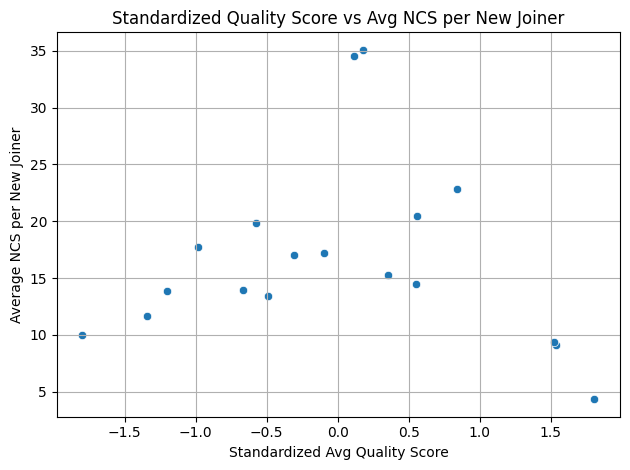

In [ ]:
from sklearn.preprocessing import StandardScaler

month_stats['quality_score_scaled'] = StandardScaler().fit_transform(month_stats[['avg_quality_score']])
sns.scatterplot(data=month_stats, x='quality_score_scaled', y='avg_ncs_per_new_joiner')
plt.title('Standardized Quality Score vs Avg NCS per New Joiner')
plt.xlabel('Standardized Avg Quality Score')
plt.ylabel('Average NCS per New Joiner')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Z-score for outlier detection
month_stats['z_ncs'] = (month_stats['avg_ncs_per_new_joiner'] - month_stats['avg_ncs_per_new_joiner'].mean()) / month_stats['avg_ncs_per_new_joiner'].std()
month_stats['z_quality'] = (month_stats['avg_quality_score'] - month_stats['avg_quality_score'].mean()) / month_stats['avg_quality_score'].std()

# Outliers: abs(z) > 2
outlier_months = month_stats[(month_stats['z_ncs'].abs() > 2) | (month_stats['z_quality'].abs() > 2)]
print("Outlier months:\n", outlier_months)


Outlier months:
   assignation_month  avg_quality_score  avg_ncs_per_new_joiner  \
5        2023-07-01       -6916.132653               35.096939   
6        2023-09-01       -7093.657895               34.557895   

   quality_score_scaled     z_ncs  z_quality  
5              0.177564  2.300739   0.172561  
6              0.116155  2.233430   0.112882  


In [ ]:
# Calculate z-scores
month_stats['z_ncs'] = (month_stats['avg_ncs_per_new_joiner'] - month_stats['avg_ncs_per_new_joiner'].mean()) / month_stats['avg_ncs_per_new_joiner'].std()
month_stats['z_quality'] = (month_stats['avg_quality_score'] - month_stats['avg_quality_score'].mean()) / month_stats['avg_quality_score'].std()

# Identify outlier months
outlier_months = month_stats[(month_stats['z_ncs'].abs() > 2) | (month_stats['z_quality'].abs() > 2)]
print("Outlier months:\n", outlier_months[['assignation_month', 'avg_ncs_per_new_joiner', 'avg_quality_score', 'z_ncs', 'z_quality']])


Outlier months:
   assignation_month  avg_ncs_per_new_joiner  avg_quality_score     z_ncs  \
5        2023-07-01               35.096939       -6916.132653  2.300739   
6        2023-09-01               34.557895       -7093.657895  2.233430   

   z_quality  
5   0.172561  
6   0.112882  


In [ ]:
for month in outlier_months['assignation_month']:
    joiners = accounts.loc[accounts['assignation_month'] == month, 'assignee'].unique()
    print(f"\nNew joiners for outlier month {month}:")
    print(joiners)




New joiners for outlier month 2023-07-01 00:00:00:
['El Hadj Toure']

New joiners for outlier month 2023-09-01 00:00:00:
['Léo Delporto']


quality_score         1.000000
days_last_purchase   -0.968300
days_last_car_view   -0.674364
nb_assignations      -0.339035
Name: quality_score, dtype: float64


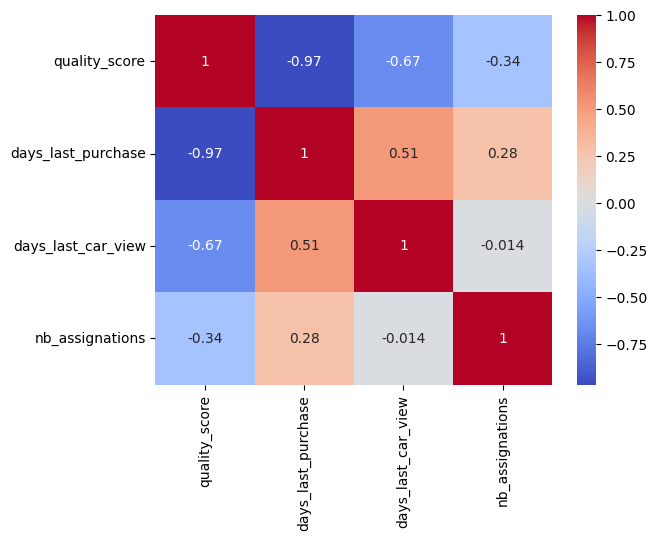

In [ ]:
corr_matrix = accounts[['quality_score', 'days_last_purchase', 'days_last_car_view', 'nb_assignations']].corr()
print(corr_matrix['quality_score'])
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [ ]:
# Combine X and y into one DataFrame for easy dropping of NaNs
data = pd.concat([X, y], axis=1).dropna()

# Separate again
X_clean = data[X.columns]
y_clean = data[y.name]

model = LinearRegression()
model.fit(X_clean, y_clean)


LinearRegression()

In [ ]:
mask = ~y.isna()
X_clean = X[mask]
y_clean = y[mask]

model = LinearRegression()
model.fit(X_clean, y_clean)


LinearRegression()

In [ ]:
importance = pd.Series(model.coef_, index=features)
print("Feature importances (linear regression):\n", importance)

Feature importances (linear regression):
 days_last_purchase    -5.417179
days_last_car_view    -3.218981
nb_assignations      -94.746747
dtype: float64


In [ ]:
from sklearn.decomposition import PCA

X_std = StandardScaler().fit_transform(accounts[features].fillna(0))
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_std)
print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.52105942 0.33682928]


In [ ]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Regression: avg_quality_score -> avg_ncs_per_new_joiner
X = month_stats[['avg_quality_score']]
y = month_stats['avg_ncs_per_new_joiner']

model = LinearRegression()
model.fit(X, y)
print(f"Linear regression coef: {model.coef_[0]:.3f}, intercept: {model.intercept_:.3f}")

# Statsmodels for p-value and confidence interval
X_const = sm.add_constant(X)
ols_model = sm.OLS(y, X_const).fit()
print(ols_model.summary())


Linear regression coef: -0.000, intercept: 15.001
                              OLS Regression Results                              
Dep. Variable:     avg_ncs_per_new_joiner   R-squared:                       0.007
Model:                                OLS   Adj. R-squared:                 -0.055
Method:                     Least Squares   F-statistic:                    0.1125
Date:                    Mon, 07 Jul 2025   Prob (F-statistic):              0.742
Time:                            10:00:26   Log-Likelihood:                -62.412
No. Observations:                      18   AIC:                             128.8
Df Residuals:                          16   BIC:                             130.6
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=18 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [ ]:
# Suppose you want to maintain the previous average NCS per new joiner
target_ncs = month_stats['avg_ncs_per_new_joiner'].mean()
required_quality = (target_ncs - model.intercept_) / model.coef_[0]
print(f"To achieve average NCS per new joiner of {target_ncs:.2f}, need avg quality score of {required_quality:.2f}")


To achieve average NCS per new joiner of 16.67, need avg quality score of -7429.44


In [ ]:
print(accounts.columns)


Index(['merchant_id', 'merchant_names', 'to_user_id', 'assignee',
       'last_assignation_date', 'created_by', 'created_by_name',
       'nb_assignations', 'lead_or_account', 'banned_date', 'ncs_alltime',
       'last_purchase_date', 'avg_bask_alltime', 'last_car_view',
       'days_last_car_view', 'days_last_bid', 'days_last_purchase',
       'days_last_assignation',
       'days_since_last_answered_call_date_by_assigned_salesrep',
       'last_login_date', 'creation_date', 'mass_assignation_day',
       'assignation_month', 'srep_email', 'purchase_bin', 'view_bin',
       'ncs_bin', 'assign_bin', 'quality_score'],
      dtype='object')


In [ ]:
import pandas as pd

today = pd.Timestamp.today()
accounts['days_since_creation'] = (today - accounts['creation_date']).dt.days


In [ ]:
import pandas as pd

today = pd.Timestamp.today()
accounts['days_since_creation'] = (today - accounts['creation_date']).dt.days

# Now filter for close_accounts
target_score = -7429.44
tolerance = 200

close_accounts = accounts[
    (accounts['quality_score'] >= target_score - tolerance) &
    (accounts['quality_score'] <= target_score + tolerance)
]

cols = [col for col in ['days_last_purchase', 'days_last_car_view', 'days_since_creation', 'ncs_alltime', 'nb_assignations'] if col in close_accounts.columns]
print(close_accounts[cols].mean())


days_last_purchase      940.482759
days_last_car_view      232.431034
days_since_creation    2189.965517
ncs_alltime              25.137931
nb_assignations          17.500000
dtype: float64


In [ ]:
cols = [col for col in ['days_last_purchase', 'days_last_car_view', 'days_since_creation', 'ncs_alltime', 'nb_assignations'] if col in accounts.columns]
print(close_accounts[cols].mean())


days_last_purchase      940.482759
days_last_car_view      232.431034
days_since_creation    2189.965517
ncs_alltime              25.137931
nb_assignations          17.500000
dtype: float64


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# 1. Select features and target
features = ['days_last_purchase', 'days_last_car_view', 'days_since_creation', 'nb_assignations']  # Add/remove as needed
X = accounts[features].fillna(0)
y = accounts['ncs_alltime'].fillna(0)

# 2. Standardize features for comparability (optional but recommended)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Fit regression
model = LinearRegression()
model.fit(X_scaled, y)

# 4. Get coefficients
coefs = pd.Series(model.coef_, index=features)
print("Feature importances (data-driven):\n", coefs)

# 5. Create a new quality score using these coefficients
accounts['data_driven_quality'] = (X_scaled * model.coef_).sum(axis=1)


Feature importances (data-driven):
 days_last_purchase    -16.690193
days_last_car_view     -0.476232
days_since_creation    22.833448
nb_assignations        -6.197538
dtype: float64


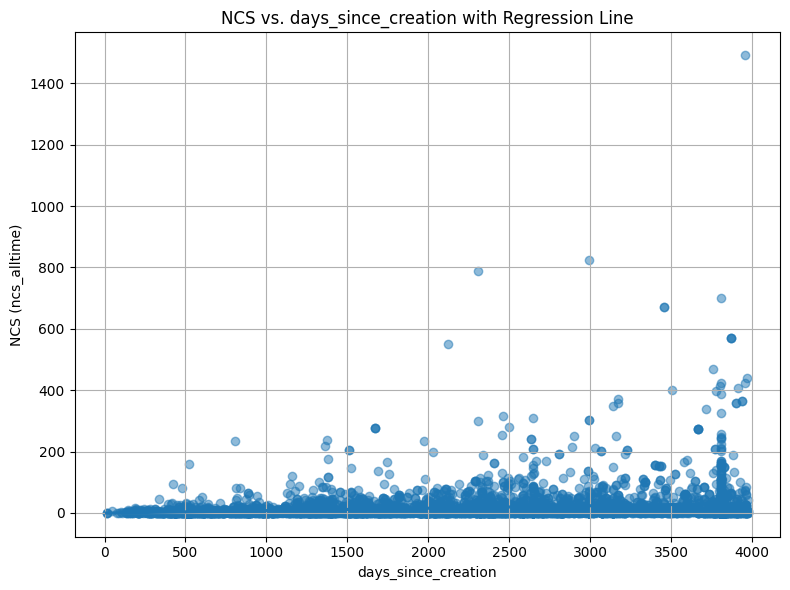

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

feature = 'days_since_creation'

plt.figure(figsize=(8,6))
sns.regplot(x=accounts[feature], y=accounts['ncs_alltime'], scatter_kws={'alpha':0.5})
plt.xlabel(feature)
plt.ylabel('NCS (ncs_alltime)')
plt.title(f'NCS vs. {feature} with Regression Line')
plt.grid(True)
plt.tight_layout()
plt.show()


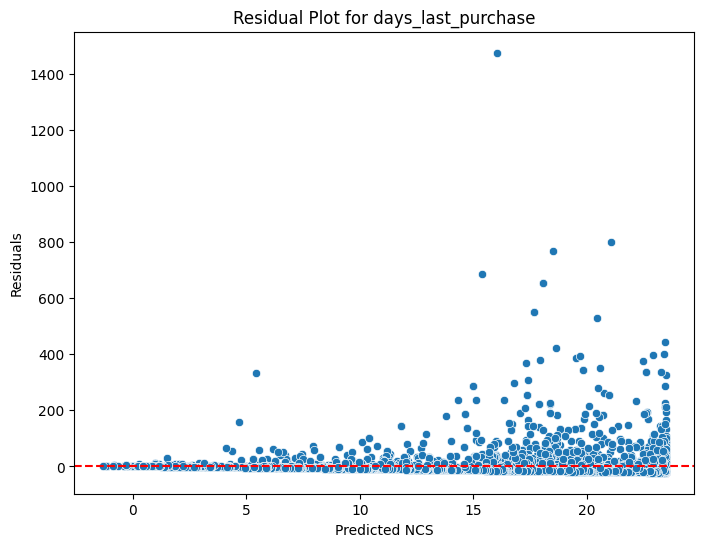

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# For single feature
feature = 'days_last_purchase'
from sklearn.linear_model import LinearRegression
import numpy as np

X_feat = accounts[[feature]].fillna(0)
y_feat = accounts['ncs_alltime'].fillna(0)
model_feat = LinearRegression().fit(X_feat, y_feat)
y_pred_feat = model_feat.predict(X_feat)
residuals = y_feat - y_pred_feat

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred_feat, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted NCS')
plt.ylabel('Residuals')
plt.title(f'Residual Plot for {feature}')
plt.show()



=== Diagnostics for days_last_purchase ===


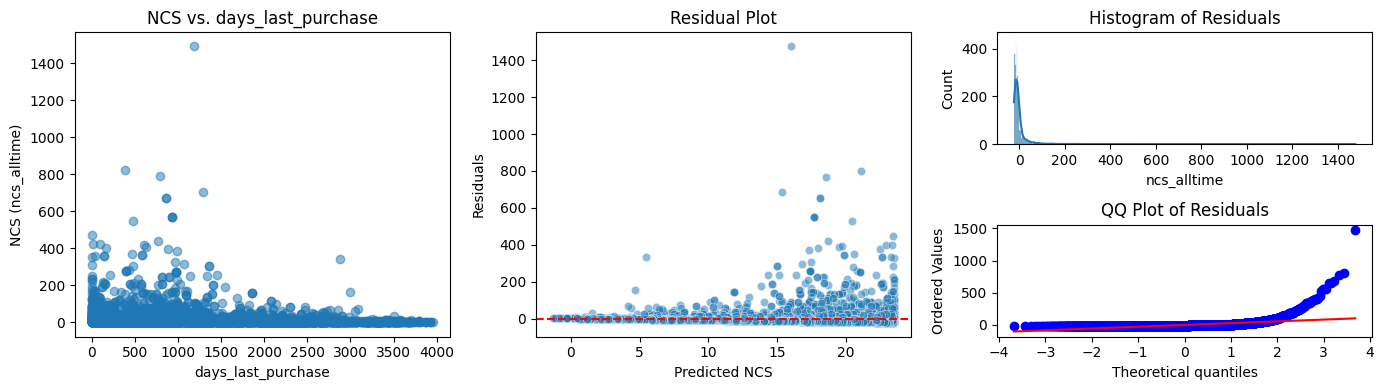


=== Diagnostics for days_last_car_view ===


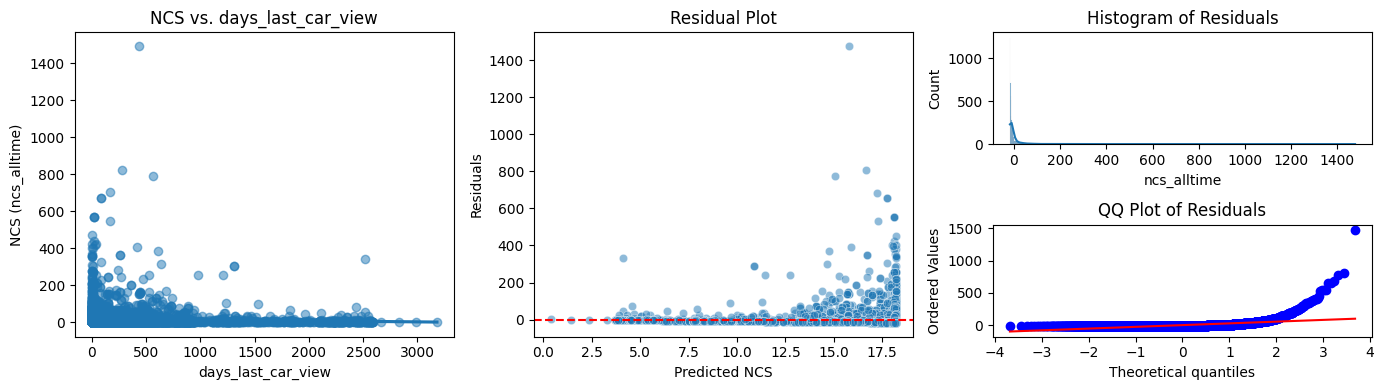


=== Diagnostics for days_since_creation ===


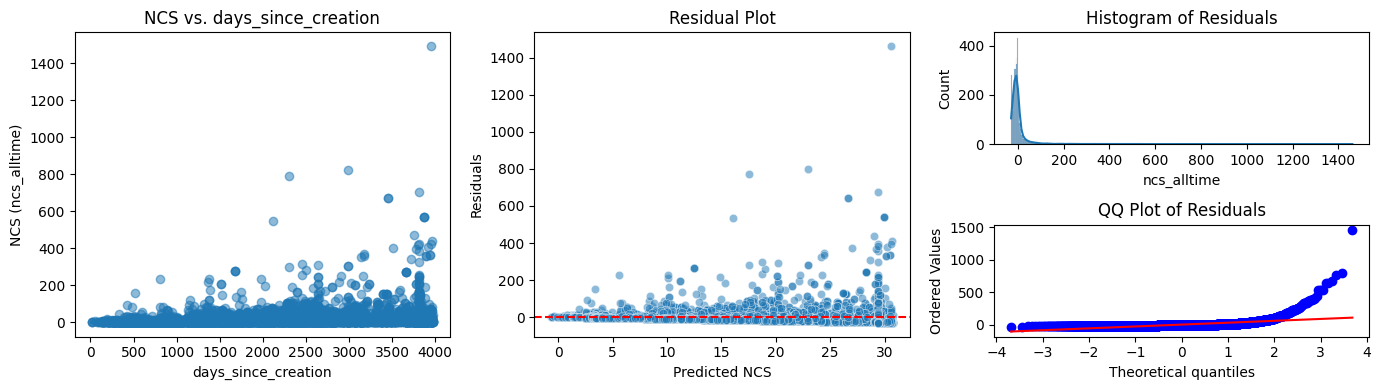


=== Diagnostics for nb_assignations ===


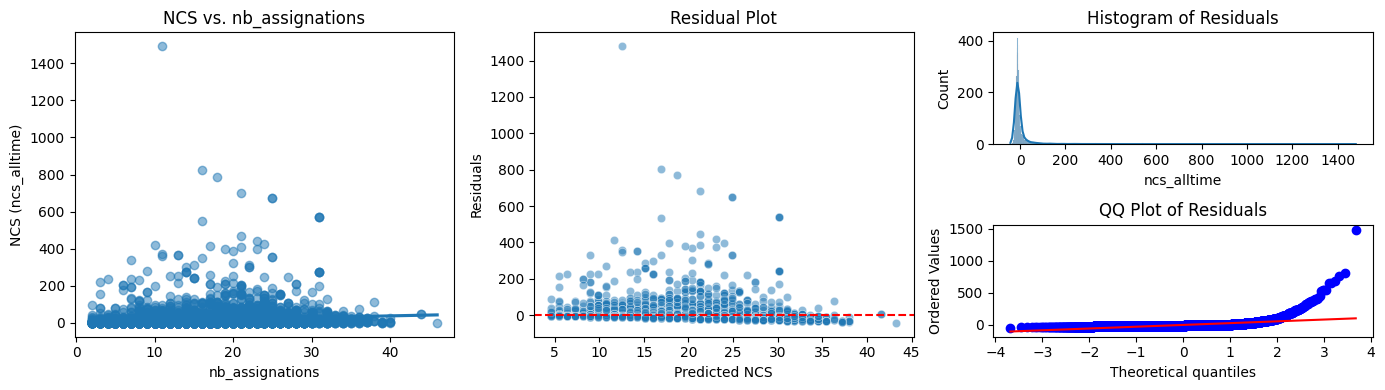

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import numpy as np

features = ['days_last_purchase', 'days_last_car_view', 'days_since_creation', 'nb_assignations']

for feature in features:
    print(f"\n=== Diagnostics for {feature} ===")
    X_feat = accounts[[feature]].fillna(0)
    y_feat = accounts['ncs_alltime'].fillna(0)
    model_feat = LinearRegression().fit(X_feat, y_feat)
    y_pred_feat = model_feat.predict(X_feat)
    residuals = y_feat - y_pred_feat

    # 1. Scatterplot with regression line
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    sns.regplot(x=accounts[feature], y=accounts['ncs_alltime'], scatter_kws={'alpha':0.5})
    plt.xlabel(feature)
    plt.ylabel('NCS (ncs_alltime)')
    plt.title(f'NCS vs. {feature}')

    # 2. Residual plot
    plt.subplot(1,3,2)
    sns.scatterplot(x=y_pred_feat, y=residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted NCS')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    # 3. Histogram of residuals
    plt.subplot(2,3,3)
    sns.histplot(residuals, kde=True)
    plt.title('Histogram of Residuals')

    # 4. QQ plot of residuals
    plt.subplot(2,3,6)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('QQ Plot of Residuals')

    plt.tight_layout()
    plt.show()


In [ ]:
accounts['log_ncs'] = np.log1p(accounts['ncs_alltime'])



=== Diagnostics for days_last_purchase ===


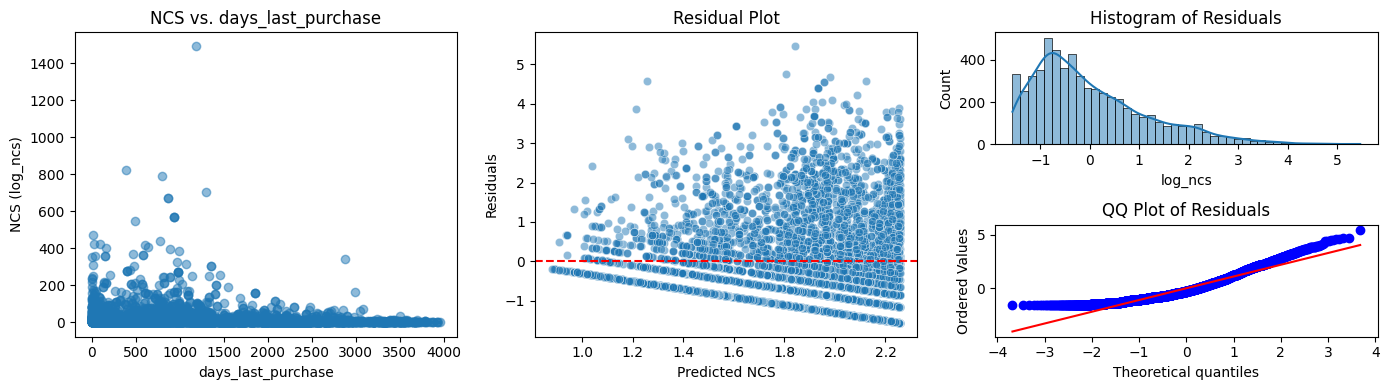


=== Diagnostics for days_last_car_view ===


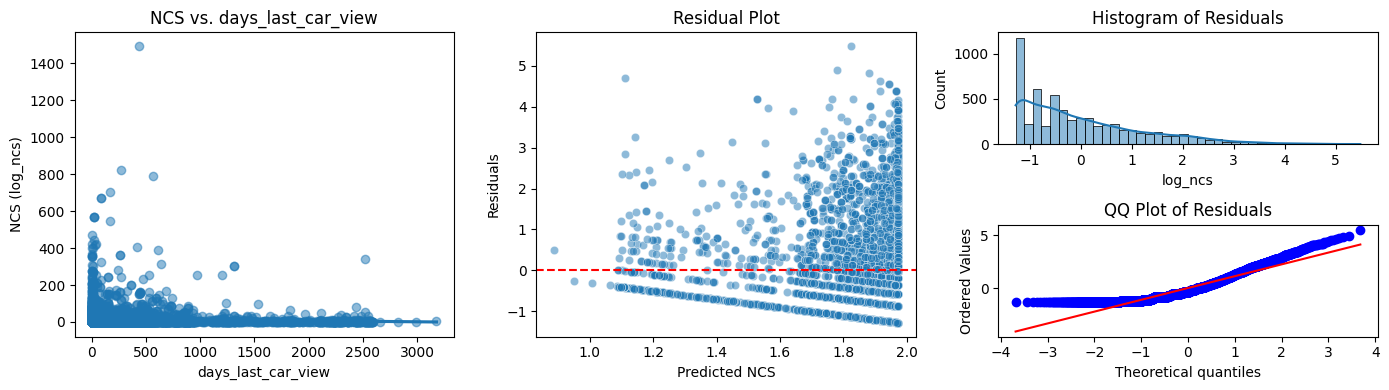


=== Diagnostics for days_since_creation ===


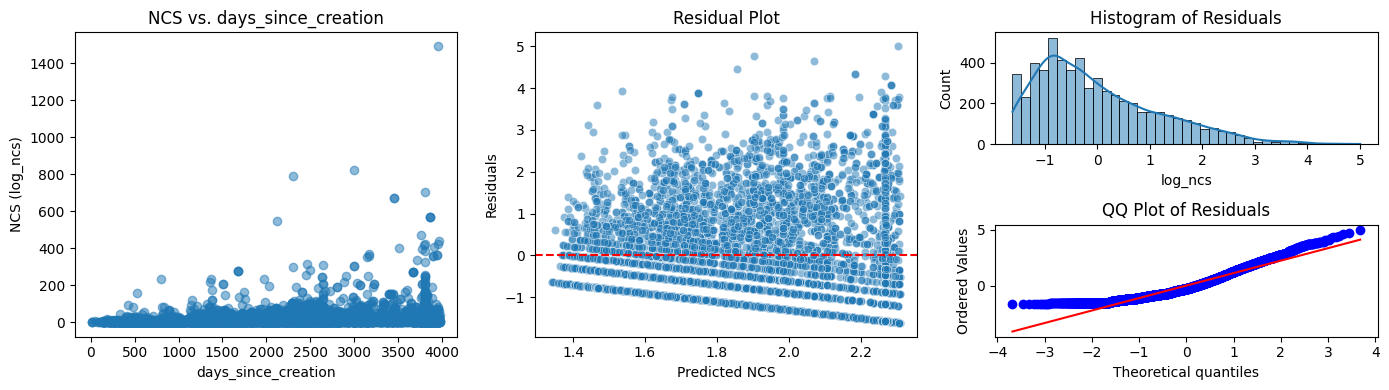


=== Diagnostics for nb_assignations ===


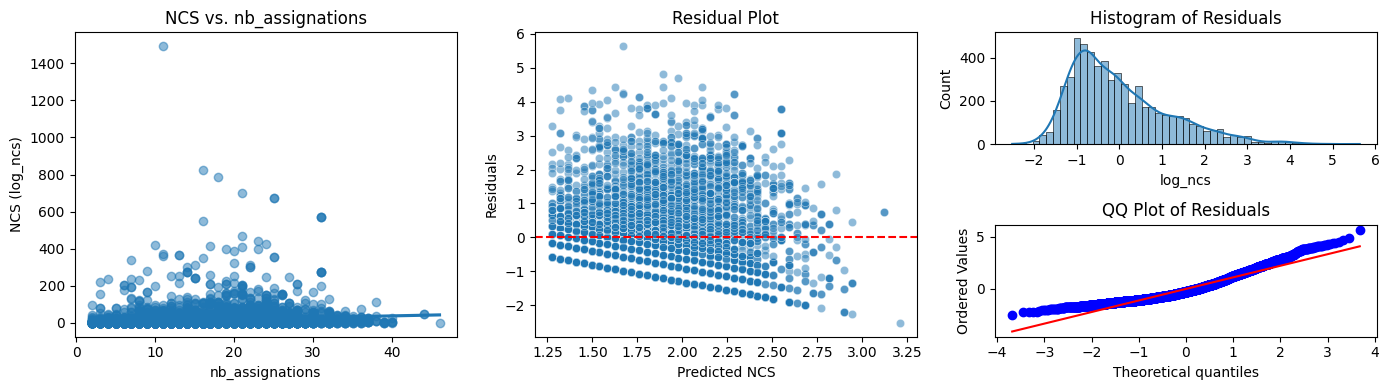

In [ ]:

import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import numpy as np

features = ['days_last_purchase', 'days_last_car_view', 'days_since_creation', 'nb_assignations']

for feature in features:
    print(f"\n=== Diagnostics for {feature} ===")
    X_feat = accounts[[feature]].fillna(0)
    y_feat = accounts['log_ncs'].fillna(0)
    model_feat = LinearRegression().fit(X_feat, y_feat)
    y_pred_feat = model_feat.predict(X_feat)
    residuals = y_feat - y_pred_feat

    # 1. Scatterplot with regression line
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1)
    sns.regplot(x=accounts[feature], y=accounts['ncs_alltime'], scatter_kws={'alpha':0.5})
    plt.xlabel(feature)
    plt.ylabel('NCS (log_ncs)')
    plt.title(f'NCS vs. {feature}')

    # 2. Residual plot
    plt.subplot(1,3,2)
    sns.scatterplot(x=y_pred_feat, y=residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted NCS')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')

    # 3. Histogram of residuals
    plt.subplot(2,3,3)
    sns.histplot(residuals, kde=True)
    plt.title('Histogram of Residuals')

    # 4. QQ plot of residuals
    plt.subplot(2,3,6)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('QQ Plot of Residuals')

    plt.tight_layout()
    plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Features and target
features = ['days_last_purchase', 'days_last_car_view', 'days_since_creation', 'nb_assignations']
X = accounts[features].fillna(0)
y = accounts['ncs_alltime'].fillna(0)  # or use log_ncs if you prefer

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
print("Random Forest R2:", r2_score(y_test, y_pred_rf))
print("Random Forest RMSE:", mean_squared_error(y_test, y_pred_rf, squared=False))


Random Forest R2: 0.41422445402739816


TypeError: got an unexpected keyword argument 'squared'

In [ ]:
import numpy as np

mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
print("Random Forest RMSE:", rmse)


Random Forest RMSE: 28.903162040910836


In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)

print("XGBoost R2:", r2_score(y_test, y_pred_xgb))
print("XGBoost RMSE:", mean_squared_error(y_test, y_pred_xgb, squared=False))


XGBoost R2: 0.3271691645267303


TypeError: got an unexpected keyword argument 'squared'

In [ ]:
import numpy as np

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
print("XGBoost RMSE:", rmse_xgb)


XGBoost RMSE: 30.976524006125313


In [ ]:
#projettant ce qu'on a avec le staffing plan
#cb de PF on peut encore créer avec notre DB actuelle avec les scores